In [4]:

# import fairseq
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import os
# torchaudio.set_audio_backend(backend='soundfile')
import datetime 
# Get the color map by name:
cm = plt.get_cmap('jet')

import yaml
import pathlib
import numpy as np
config_path=r"C:\Users\wout.decrop\environments\Imagine\imagine_environment\CLAP\config.yaml"
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

import sys
sys.path.append(r'C:\Users\wout.decrop\environments\Imagine\imagine_environment\CLAP\2_2_Model')

ModuleNotFoundError: No module named 'torch'

In [11]:
def process_filenames(d_train):
    # Create DataFrame with filenames
    df = pd.DataFrame({'filename': d_train})
    
    # Extract distance from the filename
    df['distance'] = df['filename'].apply(lambda x: float(x.split('_')[-1].split('.wav')[0]))

    # Extract speed from the filename
    df['speed'] = df['filename'].apply(lambda x: float(x.split('_')[-2].replace('-', '.')))
    df = df[df['speed'] <= 30]

    # Extract ship type from the filename
    df['ship_type'] = df['filename'].apply(lambda x: x.split('_')[-4])

    # Apply the function to create a new column 'distance_category'
    df['distance_category'] = df['distance'].apply(categorize_distance)



    # Create a combined_info column
    # df['label'] = df['ship_type'] + ' at distance ' + df['distance_category'] + ' with speed ' + df['speed_category'] + ' is ' + df['activity']
    df['label'] = ["ship"] * len(df)
    # df['activity'] = ["activity"] * len(df['activity'])
    df['speed_category'] = ["speed_category"] * len(df)
    df['activity'] = ["activity"] * len(df)
    df['label'] = df['label'] + ' at distance ' + df['distance_category'] + ' with speed ' + df['speed_category'] + ' is ' + df['activity']

    # Apply the function to create a new column 'speed_category'
    df['speed_category'] = df['speed'].apply(categorize_speed)
    # df['label']= df['distance'].apply(categorize_distance)

    # Extract activity from the filename
    df['activity'] = df['filename'].apply(lambda x: x.split('_')[-3])
    return df



In [9]:
# Function to categorize distance
def categorize_distance(distance):
    if distance >= 0 and distance < 1000:
        return '0-1 km'
    elif distance >= 1000 and distance < 2000:
        return '1-2 km'
    elif distance >= 2000 and distance < 3000:
        return '2-3 km'
    elif distance >= 3000 and distance < 4000:
        return '3-4 km'
    elif distance >= 4000 and distance < 5000:
        return '4-5 km'
    elif distance >= 5000 and distance < 6000:
        return '5-6 km'
    elif distance >= 6000 and distance < 7000:
        return '6-7 km'
    elif distance >= 7000 and distance < 8000:
        return '7-8 km'
    elif distance >= 8000 and distance < 9000:
        return '8-9 km'
    elif distance >= 9000 and distance <= 10000:
        return '9-10 km'
    else:
        return '10+ km'

In [27]:
def categorize_speed(speed):
    if speed < 2:
        return '0-2'
    elif speed < 4:
        return '2-4'
    elif speed < 6:
        return '4-6'
    elif speed < 8:
        return '6-8'
    elif speed < 10:
        return '8-10'
    elif speed < 12:
        return '10-12'
    elif speed < 14:
        return '12-14'
    elif speed < 16:
        return '14-16'
    else:
        return '17+'

In [28]:
batch_size=8
stop_shuffle=False
sample_dur=10
desired_fs = 48000
wavs_folder= pathlib.Path(config['wavs_folder'])

d_train_path= r"C:\Users\wout.decrop\environments\Imagine\imagine_environment\CLAP\2_1_Data/train.txt"
d_valid_path= r"C:\Users\wout.decrop\environments\Imagine\imagine_environment\CLAP\2_1_Data/val.txt"
d_test_path= r"C:\Users\wout.decrop\environments\Imagine\imagine_environment\CLAP\2_1_Data/test.txt"
# print("path ", d_train_path)
split = np.genfromtxt(d_train_path, dtype='str', delimiter=' ')
d_train_loc = np.array([os.path.join(wavs_folder, i) for i in split[:, 0]])

split = np.genfromtxt(d_valid_path, dtype='str', delimiter=' ')
d_valid_loc = np.array([os.path.join(wavs_folder, i) for i in split[:, 0]])

split = np.genfromtxt(d_test_path, dtype='str', delimiter=' ')
d_test_loc = np.array([os.path.join(wavs_folder, i) for i in split[:, 0]])

# split = np.genfromtxt(self.d_train_path, dtype='str', delimiter=' ')
# d_train_loc = np.array([os.path.join(self.wavs_folder, i) for i in split[:, 0]])

# split = np.genfromtxt(self.d_valid_path, dtype='str', delimiter=' ')
# d_valid_loc = np.array([os.path.join(self.wavs_folder, i) for i in split[:, 0]])
d_train=process_filenames(d_train_loc)
d_valid=process_filenames(d_valid_loc)
d_test=process_filenames(d_test_loc)
# d_train=d_train[0:100]
train_labels = set(d_train["label"])
# Count the occurrences of each label in d_train
label_counts_train = d_train["label"].value_counts()

# Filter out labels which have less than 5 samples in d_train
valid_train_labels = label_counts_train[label_counts_train >= 5].index

# Filter d_train and d_valid based on valid_train_labels
d_train = d_train[d_train["label"].isin(valid_train_labels)]
d_valid = d_valid[d_valid["label"].isin(valid_train_labels)]
# Filter d_valid based on labels present in d_train
# d_valid= d_valid[d_valid["label"].isin(train_labels)]
test_train_labels = label_counts_train[label_counts_train >= 5].index

# Filter d_train and d_test based on test_train_labels
d_train = d_train[d_train["label"].isin(test_train_labels)]
d_test = d_test[d_test["label"].isin(test_train_labels)]

# Display the number of unique classes
# Display the number of unique classes
num_classes = len(valid_train_labels)
descriptions=d_train['label'].unique()
def extract_distance_value(description):
    if '10+ km' in description:
        return 10  # Assign a numeric value for "10+ km"
    # Extract distance range and convert to numeric value
    distance_part = description.split('distance ')[1].split(' km')[0]
    start, end = distance_part.split('-')
    return (int(end) + int(start)) / 2

# Sort the array based on the numeric values
sorted_descriptions = sorted(descriptions, key=extract_distance_value)

# Convert sorted list back to numpy array
sorted_array = np.array(sorted_descriptions)
ids={lbl: i for i, lbl in enumerate(sorted_array)}


In [13]:
d_test["filename"][0]

'\\storage\\CLAP_paper\\data\\data_per_station_6_paper-window-6_10seconds-efficient_CLEANED_colouring\\GardenCity_15811_test/G_15811_2022-01-22_08-47-03_68-3827_Cargo_underway-using-engine_12-4_6675.wav'

In [16]:
def extract_speed(speed_str: str) -> float:
    if '-' in speed_str:
        lower, upper = map(int, speed_str.split('-'))
        return (lower + upper) / 2
    elif speed_str.endswith('+'):
        return float(speed_str[:-1]) + 2  # Assuming adding 2 for '+' case (from the original logic of 15+)
    else:
        return float(speed_str)


In [15]:
df = pd.concat([d_train, d_valid, d_test], ignore_index=True)

# Print the concatenated DataFrame (for verification)
print(len(df))

26465


In [16]:
def extract_date_station_from_filename(filename):
    # Extract the directory name which is the station name
    station_name = os.path.basename(os.path.dirname(filename))
    # Extract the file basename
    file_basename = os.path.basename(filename)
    # Extract the date part
    date_str = file_basename.split('_')[2]
    return station_name, datetime.datetime.strptime(date_str, '%Y-%m-%d').date()

# Apply function to each filename in the DataFrame
df['station'], df['date'] = zip(*df['filename'].apply(extract_date_station_from_filename))

# Count unique date-station combinations
unique_days_per_station = df.groupby(['station', 'date']).size().reset_index(name='count')

print("Unique days per station:")
print(unique_days_per_station)

Unique days per station:
                   station        date  count
0    GardenCity_15811_test  2022-01-22    245
1    GardenCity_15811_test  2022-04-24    240
2    GardenCity_15811_test  2022-05-04    238
3    GardenCity_15811_test  2022-05-10    236
4    GardenCity_15811_test  2022-05-20    257
..                     ...         ...    ...
111      Grafton_28434_val  2022-09-15    288
112     Grafton_29187_test  2022-10-30    289
113    Grafton_29187_train  2022-11-01    288
114    Grafton_29187_train  2022-11-03    274
115    Grafton_29187_train  2022-11-05    288

[116 rows x 3 columns]


In [32]:
df["filename"][0]

'/storage/CLAP_paper/data/data_per_station_6_paper-window-6_10seconds-efficient_CLEANED_colouring/Grafton_15810_train/G_15810_2022-04-20_10-24-12_319-075267_Other_underway-using-engine_2-7_3436.wav'

In [38]:
116-76

40

In [17]:
# df=d_valid

def extract_date_station_from_filename(filename):
    file_basename = os.path.basename(filename)
    station_name = file_basename.split('_')[0]  # Extracting the station name part, assuming it's the first segment split by '_'
    date_str = file_basename.split('_')[2]  # Extracting the date part, assuming it's the third segment split by '_'
    return station_name, datetime.datetime.strptime(date_str, '%Y-%m-%d').date()

# Apply function to each filename in the DataFrame
df['station'], df['date'] = zip(*df['filename'].apply(extract_date_station_from_filename))

# Count unique date-station combinations
unique_days_per_station = df.groupby(['station', 'date']).size().reset_index(name='count')

print("Unique days per station:")
print(unique_days_per_station)

Unique days per station:
   station        date  count
0        G  2022-01-20    237
1        G  2022-01-22    502
2        G  2022-01-24    476
3        G  2022-01-26    483
4        G  2022-01-28    331
..     ...         ...    ...
71       G  2022-09-15    288
72       G  2022-10-30    289
73       G  2022-11-01    288
74       G  2022-11-03    274
75       G  2022-11-05    288

[76 rows x 3 columns]


In [36]:
len(np.unique(df['date'] ))

76

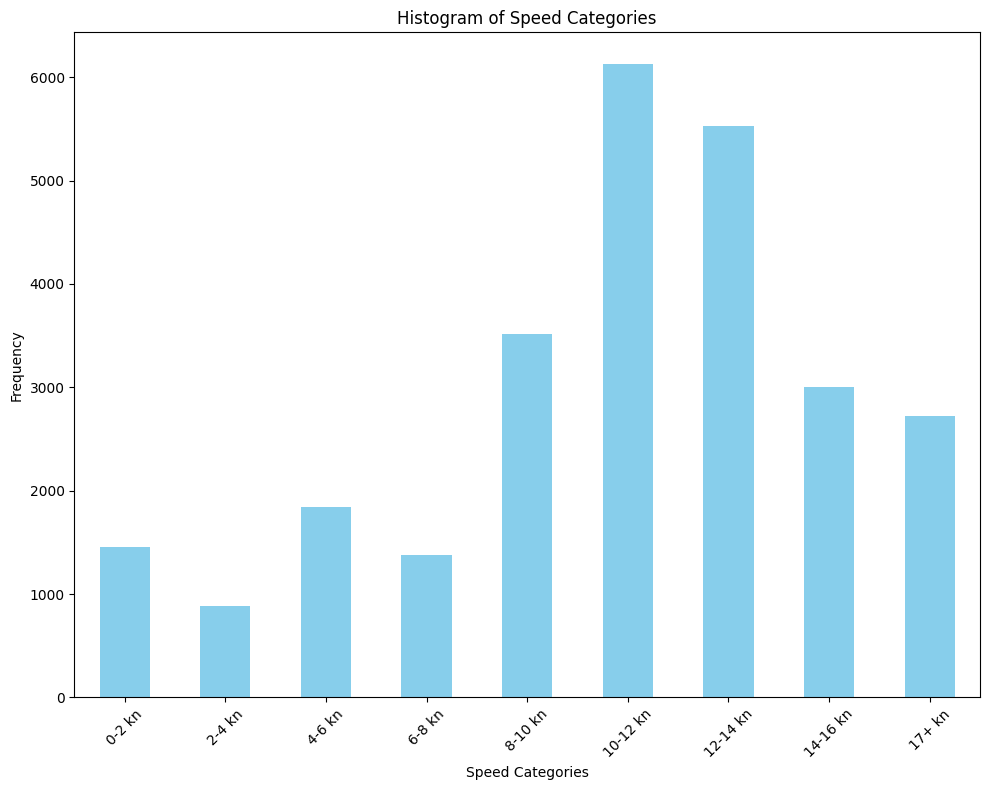

In [29]:


# Categorize speed
df['speed_category'] = df['speed'].apply(categorize_speed)

# Count the number of instances in each speed category
speed_category_counts = df['speed_category'].value_counts()

# Ensure the categories are ordered from smallest to largest speed range
categories = ['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '17+']
sorted_speed_category_counts = speed_category_counts.reindex(categories).fillna(0)

# Add 'kn' to each category label
sorted_speed_category_counts.index = sorted_speed_category_counts.index + ' kn'

# Plot histogram
plt.figure(figsize=(10, 8))
sorted_speed_category_counts.plot(kind='bar', color='skyblue')
plt.title('Histogram of Speed Categories')
plt.xlabel('Speed Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

# Ensure the directory exists
# os.makedirs('/srv/figures', exist_ok=True)

# Save the figure with a meaningful name
plt.savefig(r'C:\Users\wout.decrop\OneDrive - VLIZ\Documents\Papers\Vessel_detection\Figures\data_exploration\histograms\histogram_of_speed_categories.png')

plt.show()

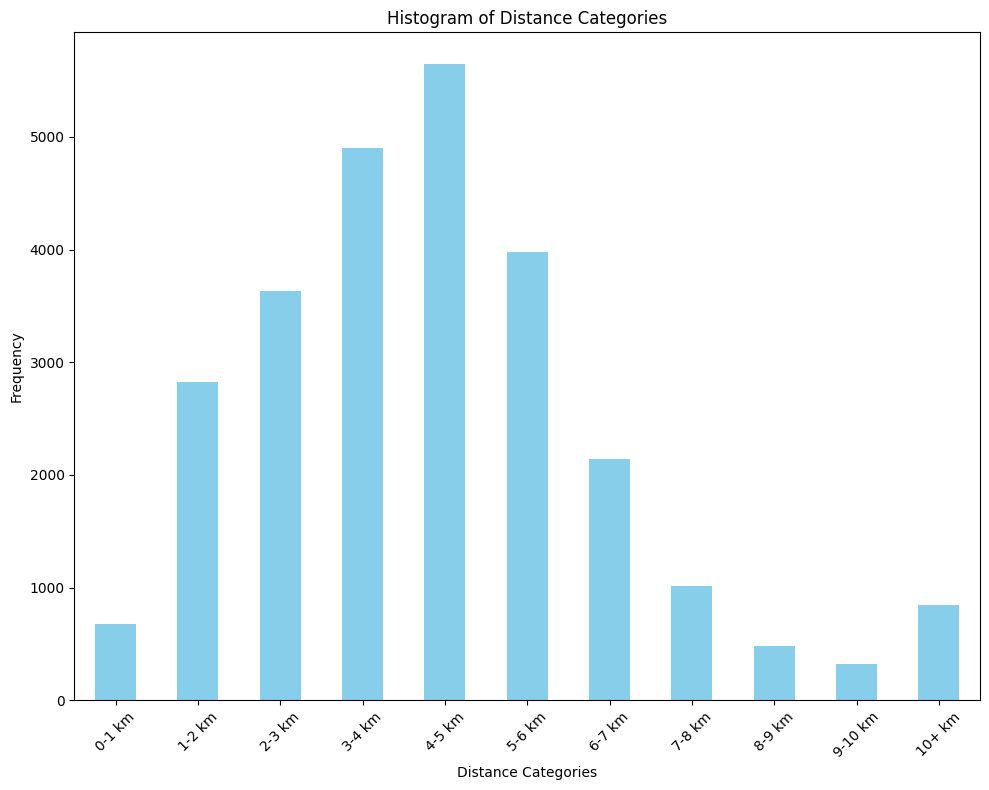

In [30]:




# Categorize distance
df['distance_category'] = df['distance'].apply(categorize_distance)

# Count the number of instances in each distance category
distance_category_counts = df['distance_category'].value_counts()

# Ensure the categories are ordered from smallest to largest distance range
distance_categories = ['0-1 km', '1-2 km', '2-3 km', '3-4 km', '4-5 km', 
                       '5-6 km', '6-7 km', '7-8 km', '8-9 km', '9-10 km', '10+ km']
sorted_distance_category_counts = distance_category_counts.reindex(distance_categories).fillna(0)

# Add 'kn' to each category label
sorted_distance_category_counts.index = sorted_distance_category_counts.index 

# Plot histogram for distance categories
plt.figure(figsize=(10, 8))
sorted_distance_category_counts.plot(kind='bar', color='skyblue')
plt.title('Histogram of Distance Categories')
plt.xlabel('Distance Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

# Ensure the directory exists
os.makedirs('/srv/figures', exist_ok=True)

# Save the distance histogram figure
plt.savefig(r'C:\Users\wout.decrop\OneDrive - VLIZ\Documents\Papers\Vessel_detection\Figures\data_exploration\histograms/histogram_of_distance_categories.png')

# Show the plot
plt.show()

In [39]:
df["filename"][0].split('/')[-1].split('_')[-4]

'underway-using-engine'

In [40]:

df['activity'].value_counts()

activity
underway-using-engine                22699
engaged-in-fishing                    1145
restricted-maneuverability            1082
moored                                 376
constrained-by-her-draught             328
underway-sailing                       243
undefined-=-default                    234
at-anchor                              228
nan                                     91
power-driven-vessel-towing-astern       39
Name: count, dtype: int64

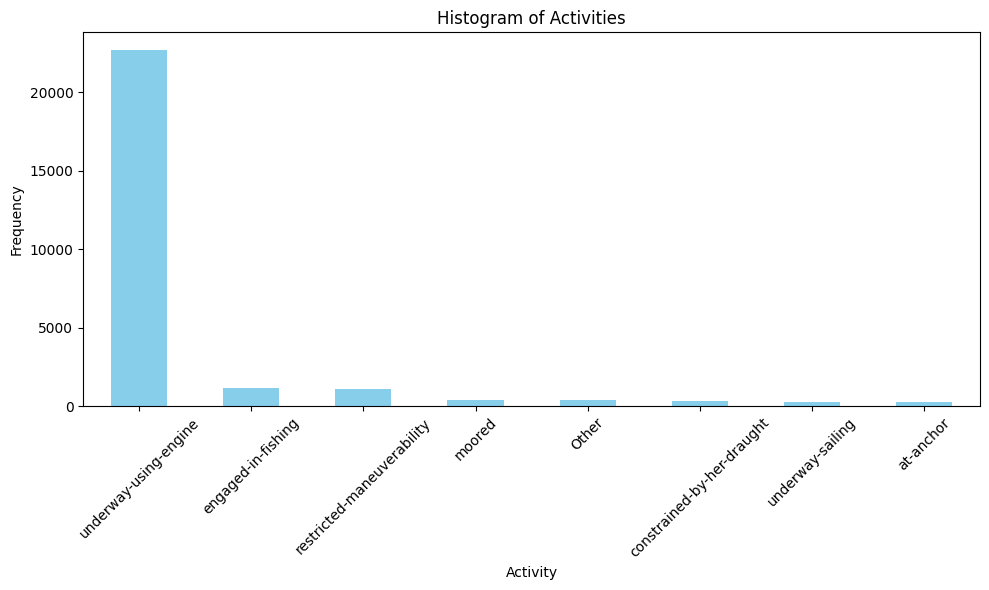

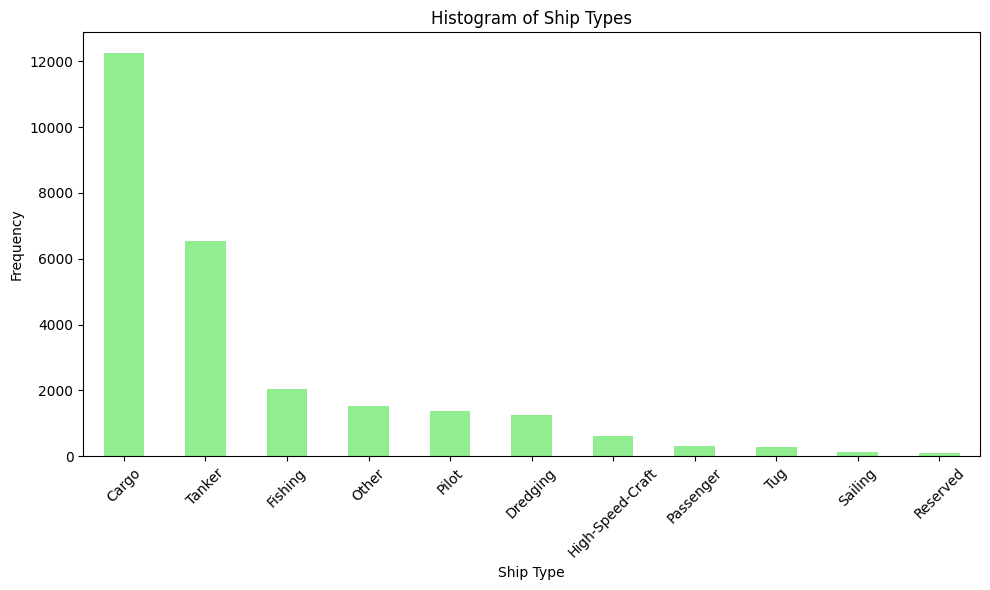

In [41]:
# Plot histograms for 'activity'
# List of activity types to group as 'Other'
small_activities = ['nan', 'undefined-=-default', 'power-driven-vessel-towing-astern']

df['activity'] = df['filename'].apply(lambda x: x.split('/')[-1].split('_')[-3])
# Replace these activity types with 'Other'
df['activity'] = df['activity'].replace(small_activities, 'Other')

plt.figure(figsize=(10, 6))
df['activity'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Histogram of Activities')
plt.xlabel('Activity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

# Ensure the directory exists
os.makedirs('/srv/figures', exist_ok=True)

# Save the activity histogram figure
plt.savefig('/srv/figures/histogram_of_activities.png')

# Show the plot
plt.show()

# Plot histograms for 'ship_type'
# Find the ship types with counts less than 100
small_ships = df['ship_type'].value_counts()[df['ship_type'].value_counts() < 100].index

# Replace these ship types with 'Other'
df['ship_type'] = df['ship_type'].replace(small_ships, 'Other')

# Plotting the histogram of ship types after grouping small ship types as 'Other'
plt.figure(figsize=(10, 6))

df['ship_type'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Histogram of Ship Types')
plt.xlabel('Ship Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the ship type histogram figure
plt.savefig(r'C:\Users\wout.decrop\OneDrive - VLIZ\Documents\Papers\Vessel_detection\Figures\data_exploration\histograms/histogram_of_ship_types.png')

# Show the plot
plt.show()

C:\Users\wout.decrop\AppData\Local\Temp\ipykernel_18400\2429996671.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10')


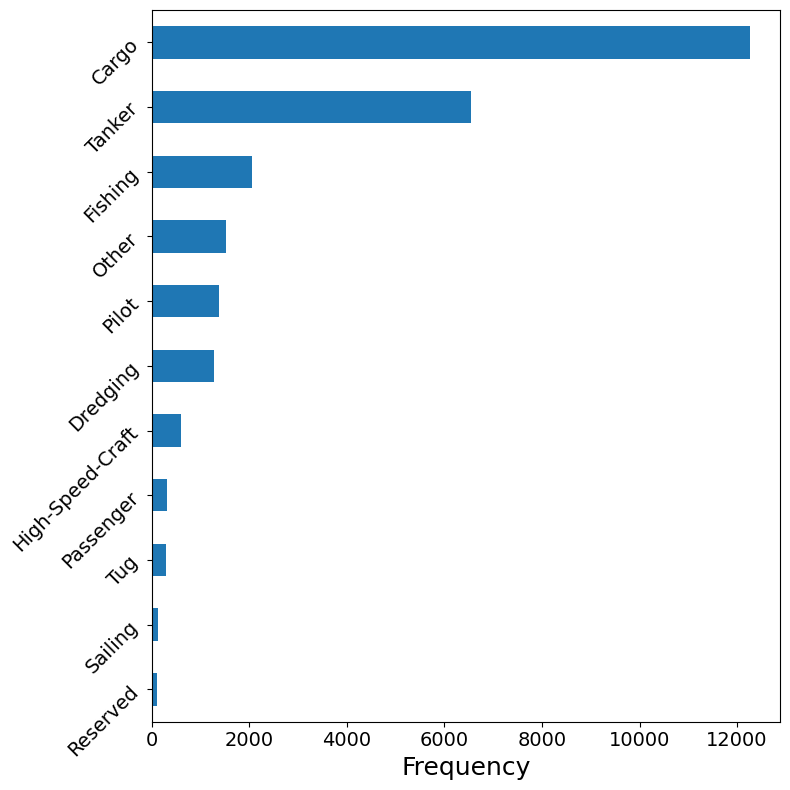

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Find the ship types with counts less than 100
small_ships = df['ship_type'].value_counts()[df['ship_type'].value_counts() < 100].index

# Replace these ship types with 'Other'
df['ship_type'] = df['ship_type'].replace(small_ships, 'Other')

# Create a colormap and select the blue color (tab10, index 0)
colormap = cm.get_cmap('tab10')
train_color = colormap(0)  # Blue

# Plotting the horizontal histogram of ship types after grouping small ship types as 'Other'
plt.figure(figsize=(8, 8))  # Adjust the figure to be more square-shaped

# Sort the value counts from big to small and apply the selected blue color
df['ship_type'].value_counts().sort_values(ascending=False).plot(kind='barh', color=train_color)

# Update title and labels with larger fonts for better readability
# plt.title('Histogram of Ship Types', fontsize=18)
plt.xlabel('Frequency', fontsize=18)

# Remove the y-axis label completely
plt.ylabel('')

# Increase size of the x and y ticks
plt.xticks(fontsize=14)
plt.yticks(rotation=45, fontsize=14)  # Rotate y-ticks by 45 degrees
plt.gca().invert_yaxis()

# Make layout tight for better fit
plt.tight_layout()

# Save the ship type histogram figure
plt.savefig(r'C:\Users\wout.decrop\OneDrive - VLIZ\Documents\Papers\Vessel_detection\Figures\data_exploration\histograms/histogram_of_ship_types.png')

# Show the plot
plt.show()


In [59]:
import pickle

# Path to the pickle file
file_path = r'\\fs\SHARED\onderzoek\6. Marine Observation Center\Projects\IMAGINE\UC6\embedding_exploration\pickles\data_with_embeddings_10sec-batch_2600-2747_my_model.pkl'

# Open the pickle file and check its length
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Check the length of the loaded data (assuming it's a list, array, or similar)
print(f"Length of the data: {len(data)}")


Length of the data: 147


In [26]:
df['ship_type'].value_counts()

ship_type
Cargo                       12267
Tanker                       6551
Fishing                      2059
Pilot                        1369
Other                        1269
Dredging                     1264
High-Speed-Craft              606
Passenger                     304
Tug                           286
Sailing                       118
Reserved                      114
Not-Available                  81
Pleasure-Craft                 75
Towing                         28
Law-Enforcement                25
Military                       25
Large-Towing                   13
S&R                             7
Anti-pollution-equipment        3
Diving                          1
Name: count, dtype: int64

In [3]:
ids={lbl: i for i, lbl in enumerate(d_train['label'].unique())}

In [4]:
ids

{'ship at distance 2-3 km with speed 9-11 is activity': 0,
 'ship at distance 6-7 km with speed 15-17 is activity': 1,
 'ship at distance 4-5 km with speed 0-2 is activity': 2,
 'ship at distance 4-5 km with speed 12-14 is activity': 3,
 'ship at distance 3-4 km with speed 9-11 is activity': 4,
 'ship at distance 2-3 km with speed 12-14 is activity': 5,
 'ship at distance 9-10 km with speed 6-8 is activity': 6,
 'ship at distance 5-6 km with speed 6-8 is activity': 7,
 'ship at distance 6-7 km with speed 0-2 is activity': 8,
 'ship at distance 6-7 km with speed 9-11 is activity': 9,
 'ship at distance 5-6 km with speed 9-11 is activity': 10,
 'ship at distance 5-6 km with speed 15-17 is activity': 11,
 'ship at distance 3-4 km with speed 12-14 is activity': 12,
 'ship at distance 1-2 km with speed 9-11 is activity': 13,
 'ship at distance 4-5 km with speed 6-8 is activity': 14,
 'ship at distance 1-2 km with speed 12-14 is activity': 15,
 'ship at distance 3-4 km with speed 3-5 is acti

In [4]:
batch_size=8
stop_shuffle=False
sample_dur=10
desired_fs = 48000
wavs_folder= '/storage/Imagine_UC6_new/DATA/data_per_station_10_updated_metadata_extra_filter'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Selected CUDA device:", torch.cuda.get_device_name(device))
else:
    print("CUDA is not available. Using CPU.")
# # device =torch.device('cuda:0')
# log_path = 'roi/BioLingual/logs_test.log'
# log_file = open(log_path, mode='w')

# detections = convert_raven_to_ae_format(labels_to_exclude=None)
# detections = detections.loc[~detections.label.isna()]

d_train_path= "data/train.txt"
d_valid_path= "data/val.txt"
d_test_path= "data/test.txt"
# print("path ", d_train_path)
split = np.genfromtxt(d_train_path, dtype='str', delimiter=' ')
d_train_loc = np.array([os.path.join(wavs_folder, i) for i in split[:, 0]])

split = np.genfromtxt(d_valid_path, dtype='str', delimiter=' ')
d_valid_loc = np.array([os.path.join(wavs_folder, i) for i in split[:, 0]])

split = np.genfromtxt(d_test_path, dtype='str', delimiter=' ')
d_test_loc = np.array([os.path.join(wavs_folder, i) for i in split[:, 0]])

# split = np.genfromtxt(self.d_train_path, dtype='str', delimiter=' ')
# d_train_loc = np.array([os.path.join(self.wavs_folder, i) for i in split[:, 0]])

# split = np.genfromtxt(self.d_valid_path, dtype='str', delimiter=' ')
# d_valid_loc = np.array([os.path.join(self.wavs_folder, i) for i in split[:, 0]])
d_train=u.process_filenames(d_train_loc)
ship_activity_categories = {
    'underway-using-engine': 'underway-using-engine',
    'restricted-maneuverability': 'restricted-maneuverability',
    'moored': 'moored',
    'engaged-in-fishing': 'engaged-in-fishing',
    'constrained-by-her-draught': 'restricted-maneuverability'
}

# # Group ship types into specified categories
d_train['activity'] = d_train['activity'].apply(lambda x: ship_activity_categories.get(x))
# d_test['activity'] = d_test['activity'].apply(lambda x: ship_activity_categories.get(x))
# d_valid['activity'] = d_valid['activity'].apply(lambda x: ship_activity_categories.get(x))

# Filter out rows with ship types not in the specified categories
d_train = d_train.dropna(subset=['activity'])
# d_test = d_test.dropna(subset=['activity'])
# d_valid = d_valid.dropna(subset=['activity'])


NameError: name 'torch' is not defined

In [7]:
train_labels = set(d_train["label"])
# Count the occurrences of each label in d_train
label_counts_train = d_train["label"].value_counts()

# Filter out labels which have less than 5 samples in d_train
valid_train_labels = label_counts_train[label_counts_train >= 5].index

# Filter d_train and d_valid based on valid_train_labels
d_train = d_train[d_train["label"].isin(valid_train_labels)]
d_valid = d_valid[d_valid["label"].isin(valid_train_labels)]
# Filter d_valid based on labels present in d_train
# d_valid= d_valid[d_valid["label"].isin(train_labels)]
test_train_labels = label_counts_train[label_counts_train >= 5].index

# Filter d_train and d_test based on test_train_labels
d_train = d_train[d_train["label"].isin(test_train_labels)]
d_test = d_test[d_test["label"].isin(test_train_labels)]

# Display the number of unique classes
num_classes = len(valid_train_labels)
ids={lbl: i for i, lbl in enumerate(d_train['label'].unique())}


In [9]:
train_labels

set()

In [1]:
classes = label_to_id 


# Create a matrix to hold the similarity values
num_classes = len(classes)
similarity_matrix = np.zeros((num_classes, num_classes))

# Define weights for each attribute
# distance_weight = 0.55
# speed_weight = 0.30
# activity_weight = 0.10
# vessel_type_weight=0


# Calculate similarity between each pair of classes
for i, class_i in enumerate(classes):
    distance_i, speed_i, activity_i, vessel_type_i = extract_features(class_i)
    for j, class_j in enumerate(classes):
        distance_j, speed_j, activity_j, vessel_type_j = extract_features(class_j)
        distance_similarity = 1 - abs(distance_i - distance_j) / 10

NameError: name 'label_to_id' is not defined

In [6]:
u.process_filenames(d_train_loc)

,filename,distance,speed,activity,ship_type,distance_category,speed_category,label
0,/storage/Imagine_UC6_new/DATA/data_per_station...,2875.0,10.1,activity,Cargo,2-3 km,9-11,ship at distance 2-3 km with speed 9-11 is act...
1,/storage/Imagine_UC6_new/DATA/data_per_station...,6316.0,14.1,activity,Cargo,6-7 km,15-17,ship at distance 6-7 km with speed 15-17 is ac...
2,/storage/Imagine_UC6_new/DATA/data_per_station...,4825.0,0.5,activity,Other,4-5 km,0-2,ship at distance 4-5 km with speed 0-2 is acti...
3,/storage/Imagine_UC6_new/DATA/data_per_station...,4074.0,10.5,activity,Cargo,4-5 km,12-14,ship at distance 4-5 km with speed 12-14 is ac...
4,/storage/Imagine_UC6_new/DATA/data_per_station...,3844.0,9.9,activity,Cargo,3-4 km,9-11,ship at distance 3-4 km with speed 9-11 is act...
...,...,...,...,...,...,...,...,...
18910,/storage/Imagine_UC6_new/DATA/data_per_station...,4940.0,13.4,activity,Pilot,4-5 km,12-14,ship at distance 4-5 km with speed 12-14 is ac...
18911,/storage/Imagine_UC6_new/DATA/data_per_station...,3749.0,1.1,activity,Fishing,3-4 km,0-2,ship at distance 3-4 km with speed 0-2 is acti...
18912,/storage/Imagine_UC6_new/DATA/data_per_station...,6607.0,2.6,activity,Tanker,6-7 km,3-5,ship at distance 6-7 km with speed 3-5 is acti...
18913,/storage/Imagine_UC6_new/DATA/data_per_station...,2183.0,12.7,activity,Other,2-3 km,12-14,ship at distance 2-3 km with speed 12-14 is ac...


In [6]:
classes = {lbl: i for i, lbl in enumerate(d_train['label'].unique())}

In [12]:
df=d_train[['speed_category','distance_category']]

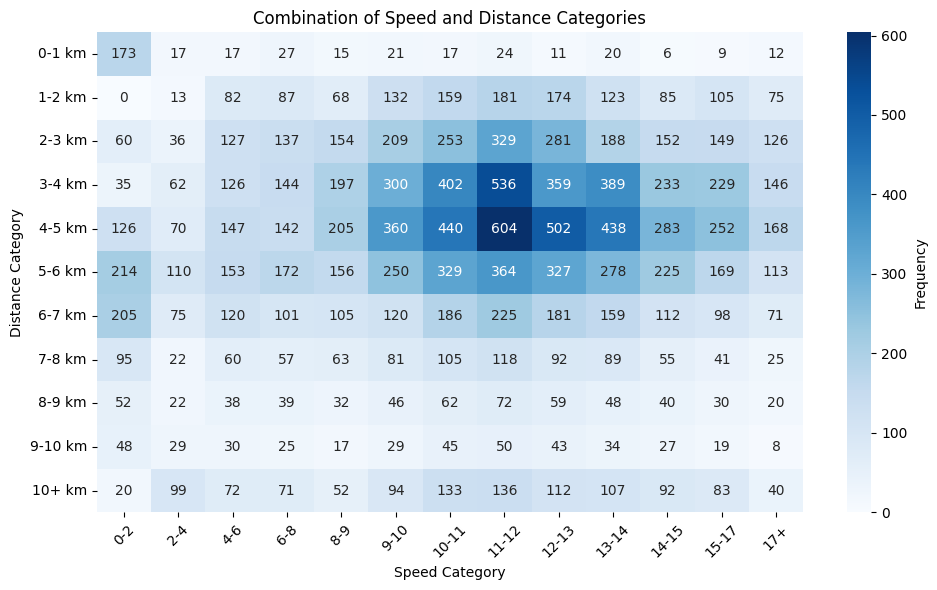

In [21]:

# Sort speed and distance categories
def sort_key(x):
    if x.endswith('+'):
        return float('17')
    if x.endswith('+ km'):
        return 10
    return int(x.split('-')[0])

speed_categories = sorted(df['speed_category'].unique(), key=sort_key)
distance_categories = sorted(df['distance_category'].unique(), key=sort_key)

# Pivot table to get counts
pivot_table = df.pivot_table(index='distance_category', columns='speed_category', aggfunc='size', fill_value=0)

# Reindex with sorted categories
pivot_table = pivot_table.reindex(index=distance_categories, columns=speed_categories)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='g', cbar_kws={'label': 'Frequency'})
plt.title('Combination of Speed and Distance Categories')
plt.xlabel('Speed Category')
plt.ylabel('Distance Category')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
def extract_speed(speed_str):
    if '-' in speed_str:
        lower, upper = map(int, speed_str.split('-'))
        return (lower + upper) / 2
    else:
        return 17 if speed_str == '15+' else int(speed_str.split('-')[0])

In [7]:
def extract_features(class_string):
    parts = class_string.split(' ')
    distance_str = parts[3]
    speed_str = parts[-3]
    distance_str_cleaned = distance_str.replace('+', '')

    distance = int(distance_str_cleaned.split('-')[0])
    speed = extract_speed(speed_str)
    activity = parts[-1]
    vessel_type = parts[0]
    return distance, speed, activity, vessel_type


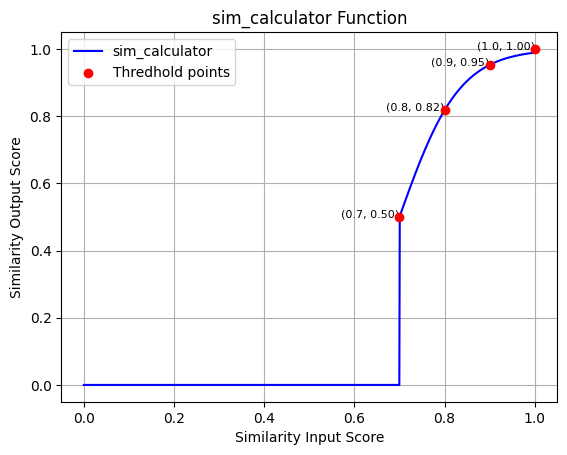

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def custom_sigmoid(x, a, b):
    return 1 / (1 + np.exp(-a * (x - b)))

def sim_calculator(x):
    a = 15  # Adjust this parameter to control the steepness of the curve
    b = 0.7
    if x < 0.7:
        return 0
    elif x == 1:
        return 1
    else:
        return custom_sigmoid(x, a, b)

# Generate x values
x_values = np.linspace(0, 1, 1000)

# Calculate y values using sim_calculator function
y_values = [sim_calculator(x) for x in x_values]

# Plot the function
plt.plot(x_values, y_values, color='blue', label='sim_calculator')

# Add dots at specific values (0.1, 0.2, ..., 1)
specific_x_values = np.arange(0.7, 1.0001, 0.1)
specific_y_values = [sim_calculator(x) for x in specific_x_values]
specific_y_values[-1]=1.0

# Plot the dots
plt.scatter(specific_x_values, specific_y_values, color='red', zorder=5, label='Thredhold points')

# Annotate the points
for (x, y) in zip(specific_x_values, specific_y_values):
    plt.text(x, y, f'({x:.1f}, {y:.2f})', fontsize=8, ha='right')

plt.title('sim_calculator Function')
plt.xlabel('Similarity Input Score')
plt.ylabel('Similarity Output Score')
plt.grid(True)
plt.legend()
plt.show()


In [12]:
specific_y_values

[0, 0.5, 0.8175744761936437, 0.9525741268224331, 0.9890130573694068]

In [8]:
classes = {lbl: i for i, lbl in enumerate(d_train['label'].unique())}


# Create a matrix to hold the similarity values
num_classes = len(classes)
similarity_matrix = np.zeros((num_classes, num_classes))

# Define weights for each attribute
# distance_weight = 0.55
# speed_weight = 0.30
# activity_weight = 0.10
# vessel_type_weight=0


# Calculate similarity between each pair of classes
for i, class_i in enumerate(classes):
    distance_i, speed_i, activity_i, vessel_type_i = extract_features(class_i)
    for j, class_j in enumerate(classes):
        distance_j, speed_j, activity_j, vessel_type_j = extract_features(class_j)
        distance_similarity = 1 - abs(distance_i - distance_j) / 10
        distance_similarity = sim_calculator(distance_similarity)

        speed_similarity = 1 - abs(speed_i - speed_j) / 16
        speed_similarity = sim_calculator(speed_similarity)
        
        # distance_similarity = distance_similarity ** 2 
        speed_similarity = 1 if speed_i == speed_j else 0
        

In [9]:
speed_i

11.5

In [10]:
speed_j

11.5

In [8]:
d_train["activity"].value_counts()

activity
underway-using-engine         83
restricted-maneuverability     7
engaged-in-fishing             3
moored                         3
constrained-by-her-draught     2
underway-sailing               1
at-anchor                      1
Name: count, dtype: int64

In [7]:
d_train["speed_category"].value_counts()

speed_category
10-15    53
5-10     26
0-5      14
15+       7
Name: count, dtype: int64

In [36]:
df=filtered_d_train["filename"].apply(lambda x: float(x.split('_')[-3].replace('-', '.')))

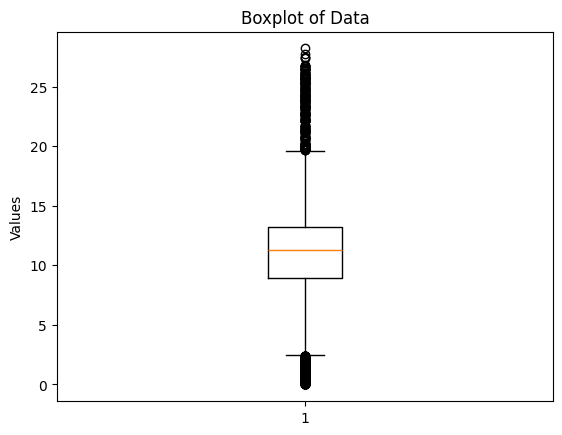

In [35]:
import matplotlib.pyplot as plt

df = filtered_d_train["filename"].apply(lambda x: float(x.split('_')[-3].replace('-', '.')))
df = df[df <= 30]
boxplot_dict=plt.boxplot(df)
plt.title('Boxplot of Data')
plt.ylabel('Values')
plt.show()

In [5]:
def categorize_speed(speed):
    if speed >= 0 and speed < 2:
        return '0-2'
    elif speed >= 2 and speed < 4:
        return '2-4'
    elif speed >= 4 and speed < 6:
        return '4-6'
    elif speed >= 6 and speed < 8:
        return '6-8'
    elif speed >= 8 and speed < 9:
        return '8-9'
    elif speed >= 9 and speed < 10:
        return '9-10'
    elif speed >= 10 and speed < 11:
        return '10-11'
    elif speed >= 11 and speed < 12:
        return '11-12'
    elif speed >= 12 and speed < 13:
        return '12-13'
    elif speed >= 13 and speed < 14:
        return '13-14'
    elif speed >= 14 and speed < 15:
        return '14-15'
    elif speed >= 15 and speed < 17:
        return '15-17'
    else:
        return '17+'



In [32]:
df

0        10.1
1        14.1
2         0.5
3        10.5
4         9.9
         ... 
18910    13.4
18911     1.1
18912     2.6
18913    12.7
18914     6.0
Name: filename, Length: 18729, dtype: float64

NameError: name 'filtered_d_train' is not defined

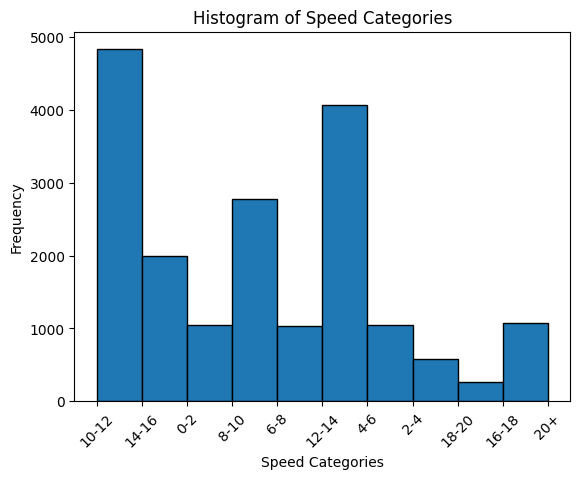

In [30]:
data=df.apply(categorize_speed)
plt.hist(data, bins=10, edgecolor='black')
plt.title('Histogram of Speed Categories')
plt.xlabel('Speed Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [14]:
filtered_d_train = d_train[d_train['label'].isin(valid_train_labels)]
filtered_d_train

,filename,distance,speed,activity,ship_type,distance_category,speed_category,label
0,/storage/Imagine_UC6_new/DATA/data_per_station...,3331.0,9.2,underway-using-engine,Tanker,3-4 km,8.2-13.3,Tanker at distance 3-4 km with speed 8.2-13.3 ...
1,/storage/Imagine_UC6_new/DATA/data_per_station...,7933.0,8.7,underway-using-engine,Cargo,7-8 km,8.2-13.3,Cargo at distance 7-8 km with speed 8.2-13.3 i...
2,/storage/Imagine_UC6_new/DATA/data_per_station...,3768.0,12.7,underway-using-engine,Tanker,3-4 km,8.2-13.3,Tanker at distance 3-4 km with speed 8.2-13.3 ...
3,/storage/Imagine_UC6_new/DATA/data_per_station...,2557.0,2.6,underway-using-engine,Tanker,2-3 km,1.5-8.2,Tanker at distance 2-3 km with speed 1.5-8.2 i...
4,/storage/Imagine_UC6_new/DATA/data_per_station...,4377.0,12.7,underway-using-engine,Cargo,4-5 km,8.2-13.3,Cargo at distance 4-5 km with speed 8.2-13.3 i...
...,...,...,...,...,...,...,...,...
13150,/storage/Imagine_UC6_new/DATA/data_per_station...,6612.0,5.8,engaged-in-fishing,Fishing,6-7 km,1.5-8.2,Fishing at distance 6-7 km with speed 1.5-8.2 ...
13151,/storage/Imagine_UC6_new/DATA/data_per_station...,550.0,0.4,restricted-maneuverability,Other,0-1 km,0-1.5,Other at distance 0-1 km with speed 0-1.5 is r...
13152,/storage/Imagine_UC6_new/DATA/data_per_station...,3080.0,25.1,underway-using-engine,High-Speed-Craft,3-4 km,13.3+,High-Speed-Craft at distance 3-4 km with speed...
13153,/storage/Imagine_UC6_new/DATA/data_per_station...,5679.0,11.9,underway-using-engine,Pilot,5-6 km,8.2-13.3,Pilot at distance 5-6 km with speed 8.2-13.3 i...


In [38]:
boxplot_dict["whiskers"][0].get_ydata()

array([8.9, 2.5])

In [39]:
boxplot_dict["whiskers"][1].get_ydata()

array([13.2, 19.6])

/tmp/ipykernel_9598/1789275115.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis', len(ship_type_counts))


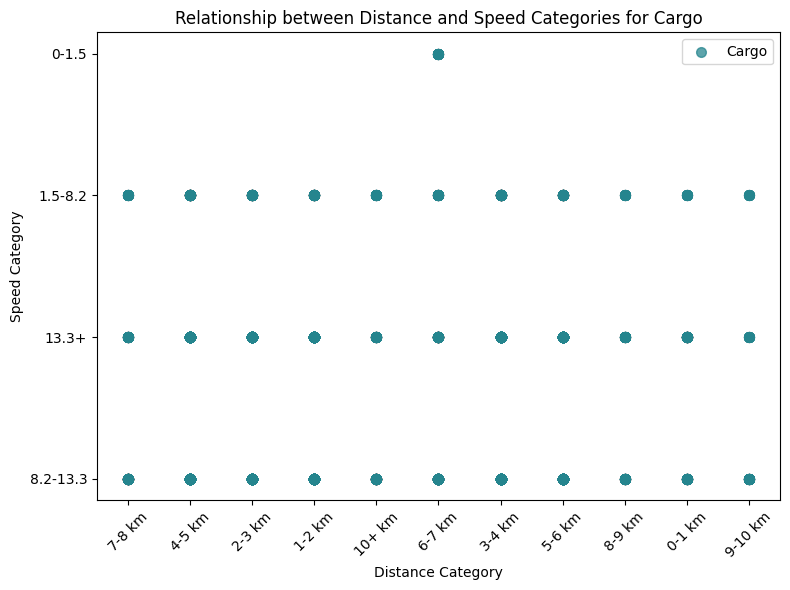

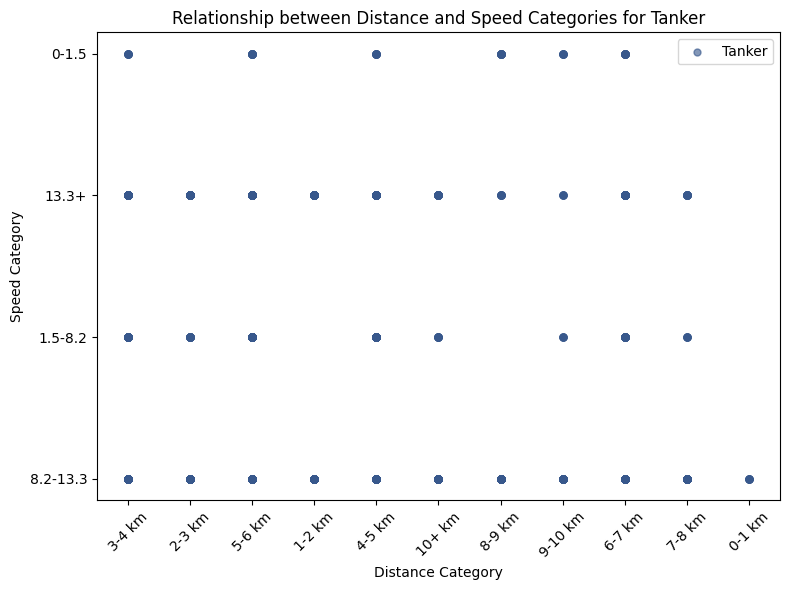

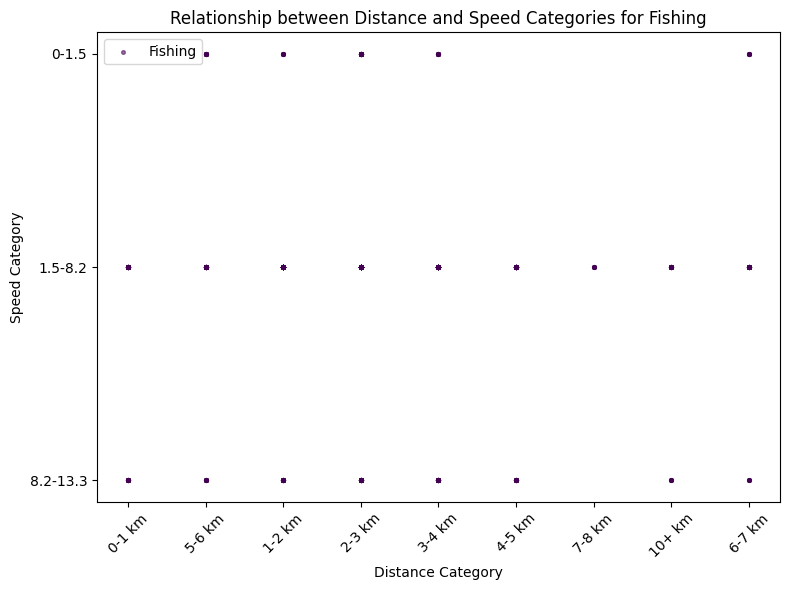

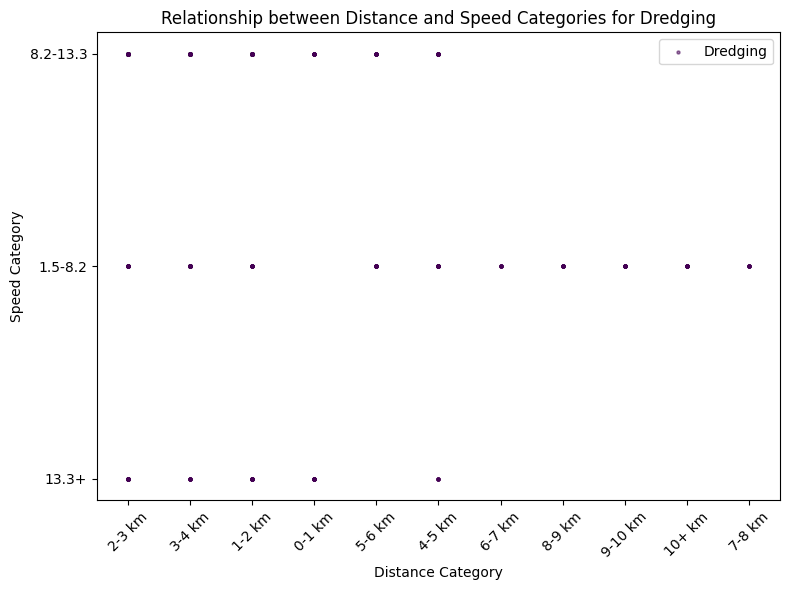

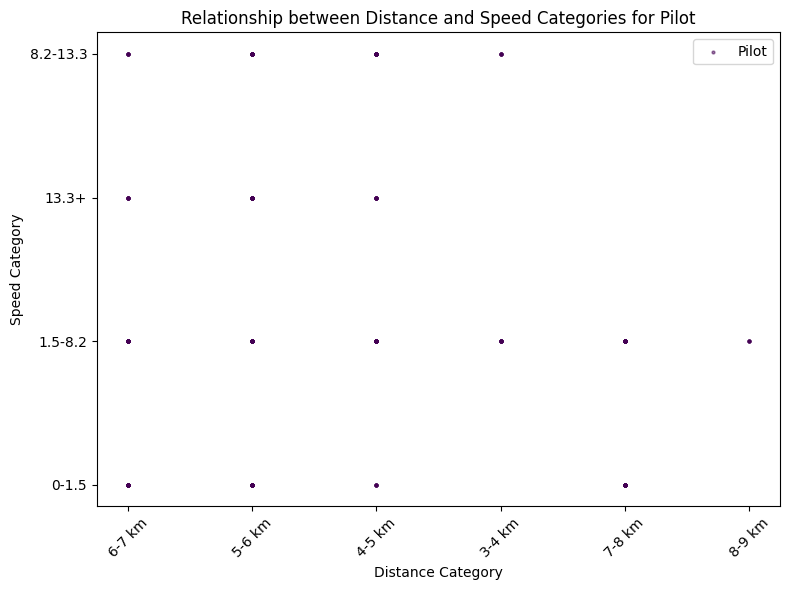

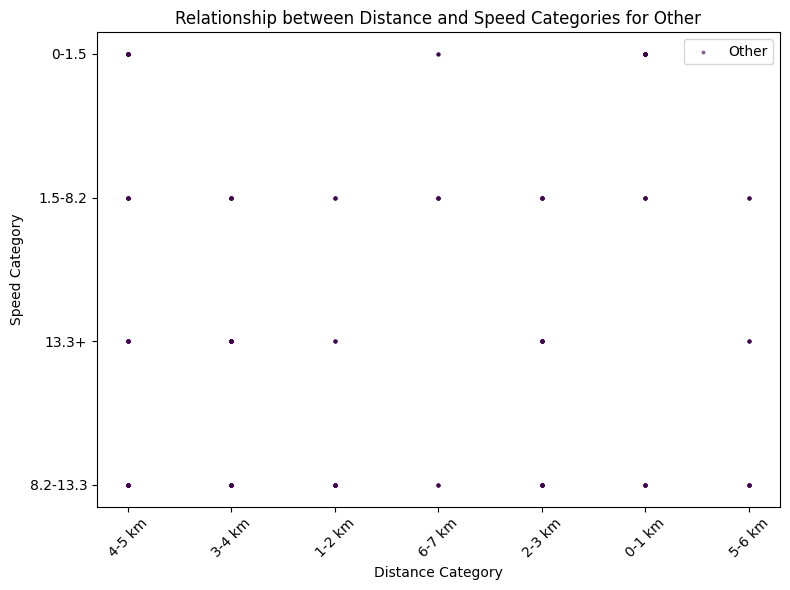

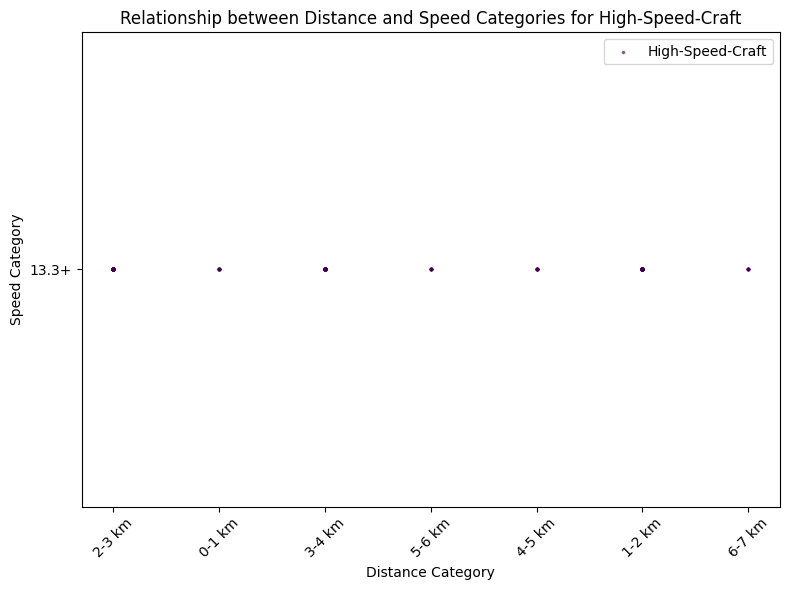

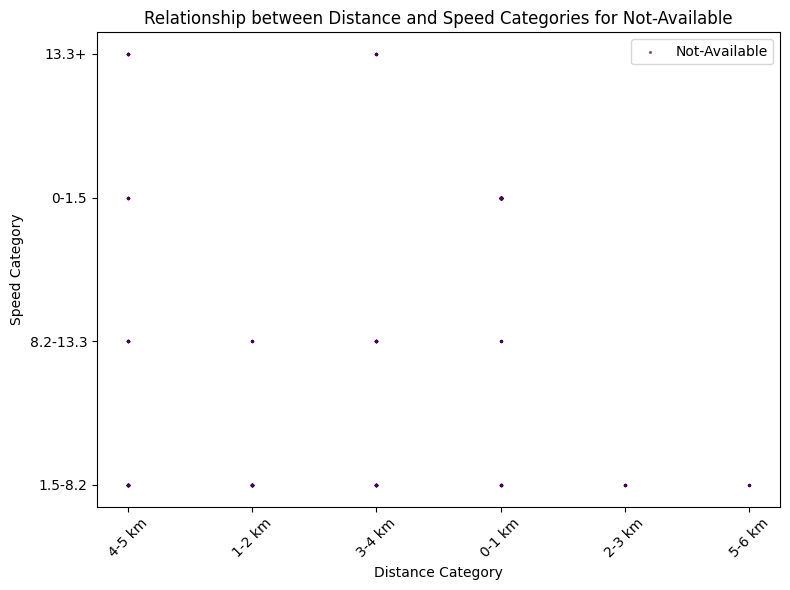

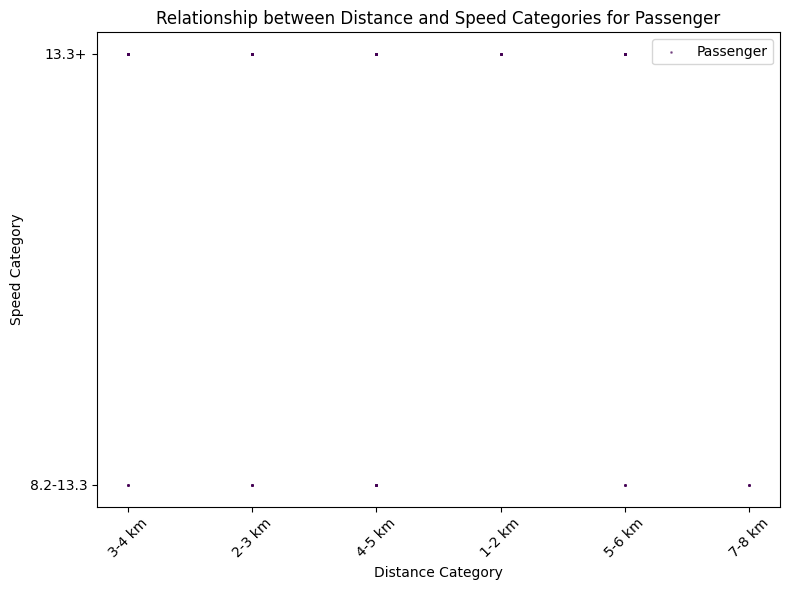

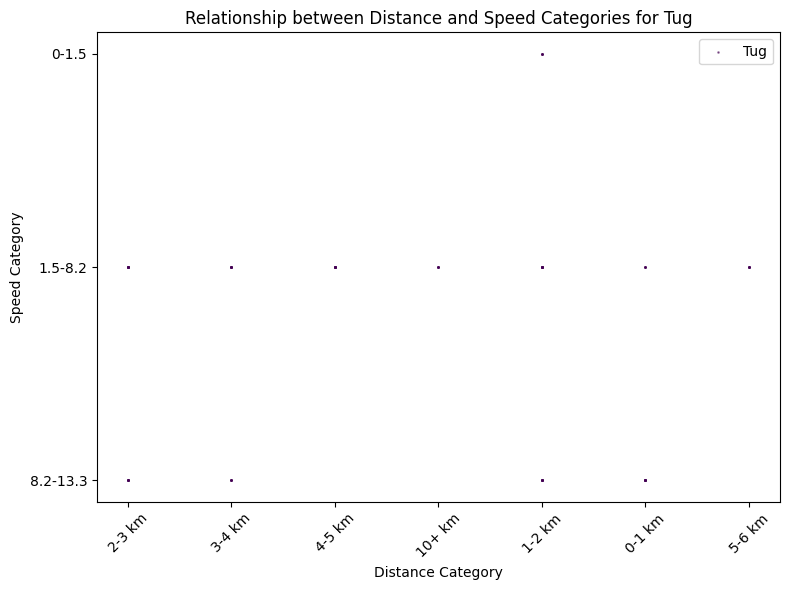

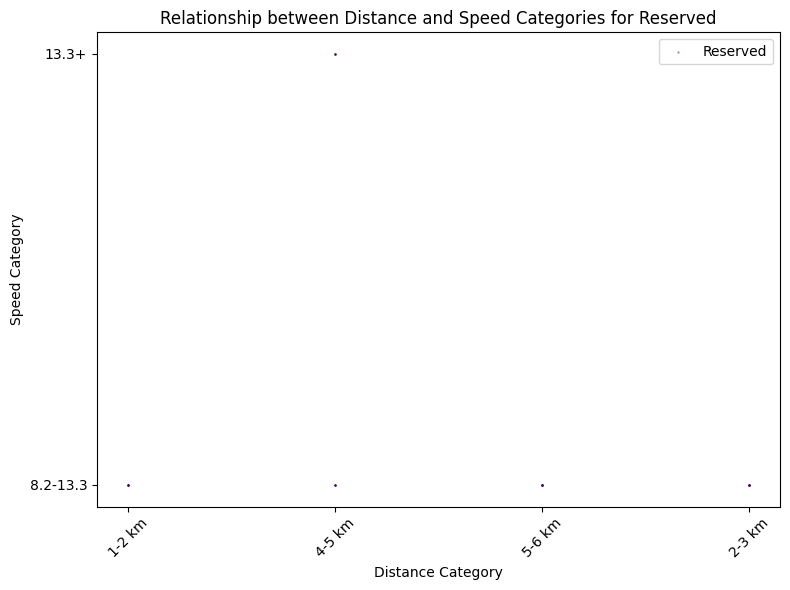

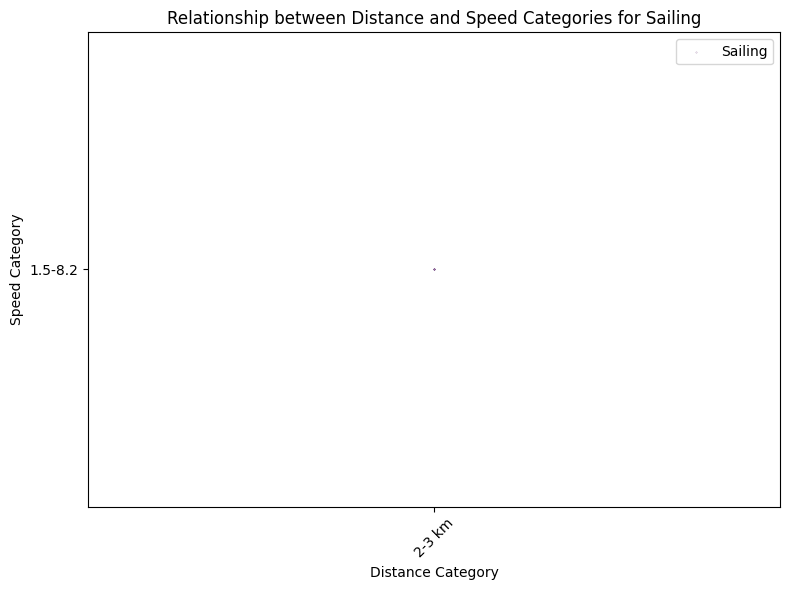

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of occurrences of each ship type
ship_type_counts = filtered_d_train['ship_type'].value_counts()

# Create a colormap based on the abundance of ship types
colormap = plt.cm.get_cmap('viridis', len(ship_type_counts))

# Plotting
for ship_type, count in ship_type_counts.items():
    ship_data = filtered_d_train[filtered_d_train['ship_type'] == ship_type]
    plt.figure(figsize=(8, 6))
    
    # Calculate size or brightness based on occurrence
    size = 100 * (ship_data.shape[0] / len(filtered_d_train))
    alpha = 0.5 + 0.5 * (ship_data.shape[0] / len(filtered_d_train))

    # Plot points with color based on colormap
    plt.scatter(ship_data['distance_category'], ship_data['speed_category'], color=colormap(ship_type_counts[ship_type]/len(filtered_d_train)), s=size, alpha=alpha, label=ship_type)

    plt.xlabel('Distance Category')
    plt.ylabel('Speed Category')
    plt.title(f'Relationship between Distance and Speed Categories for {ship_type}')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()


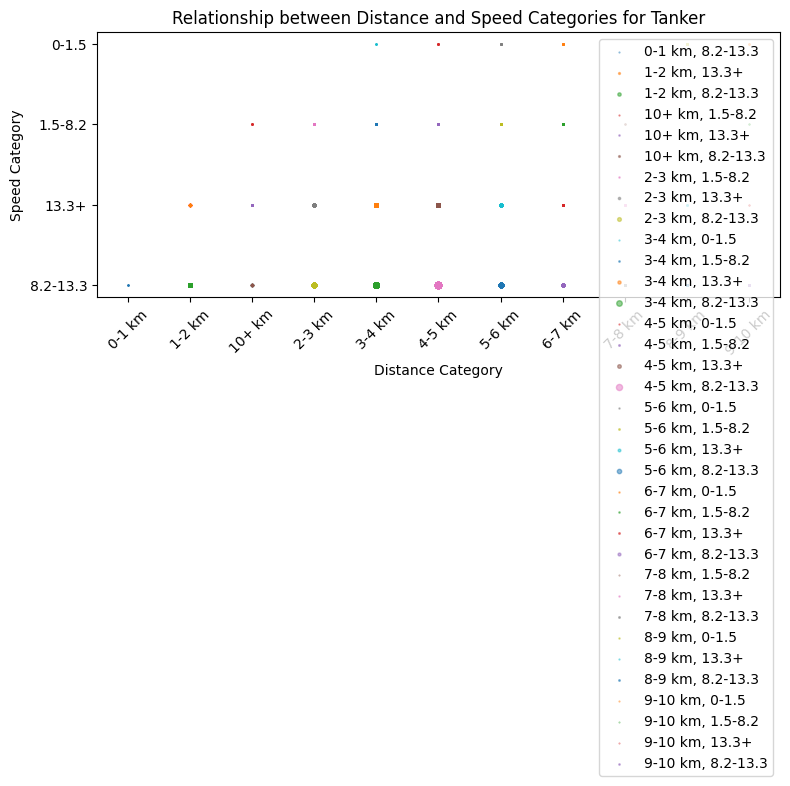

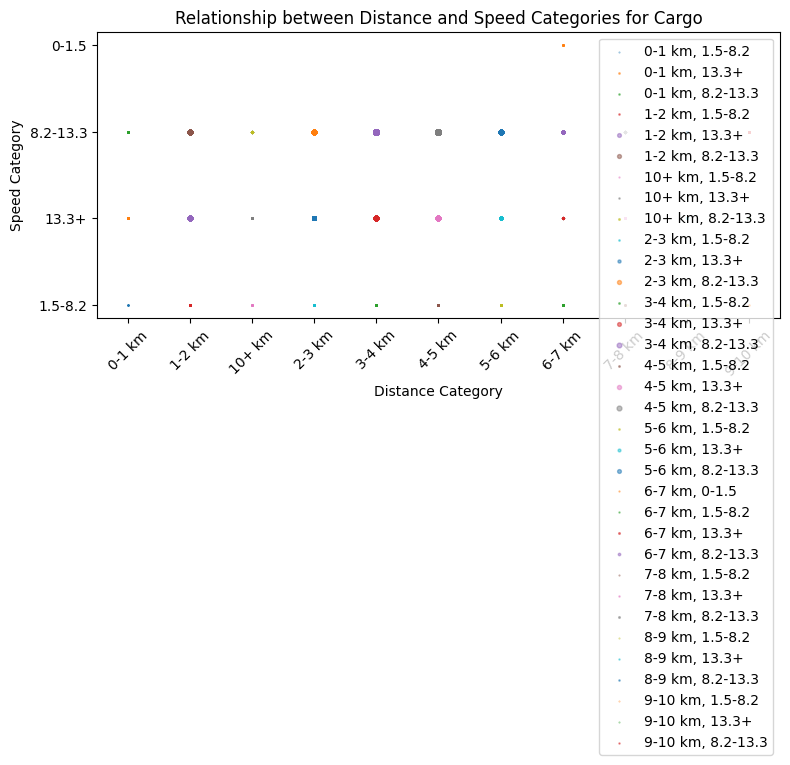

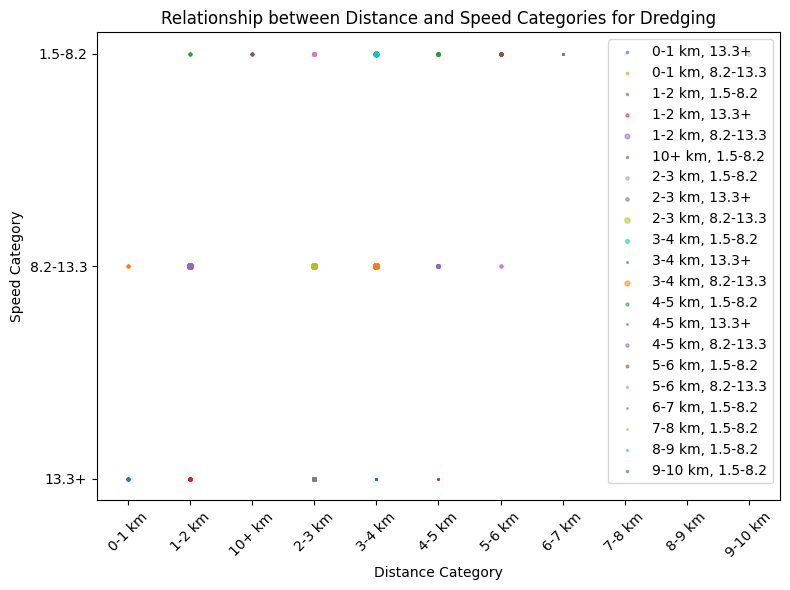

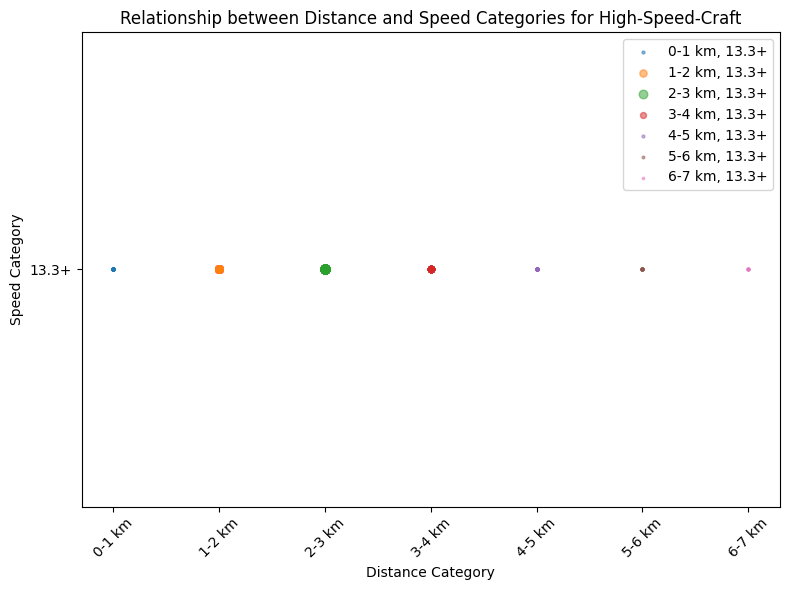

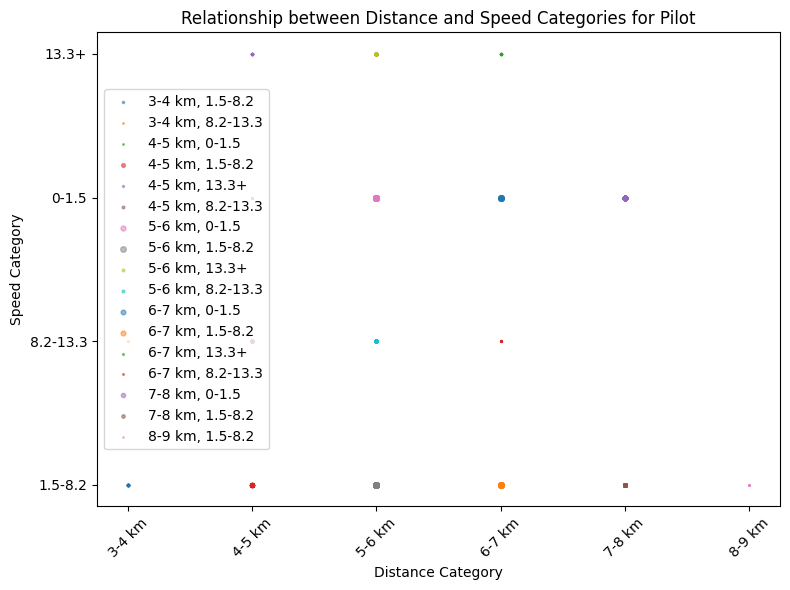

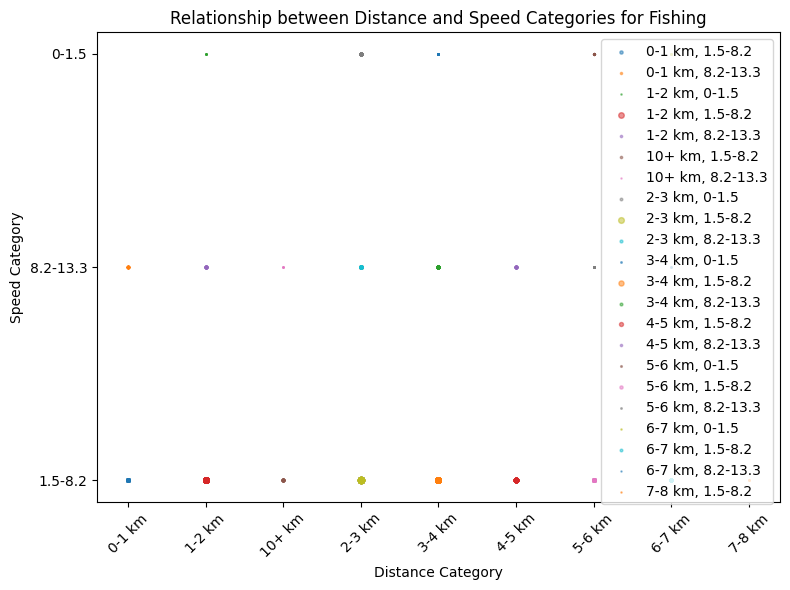

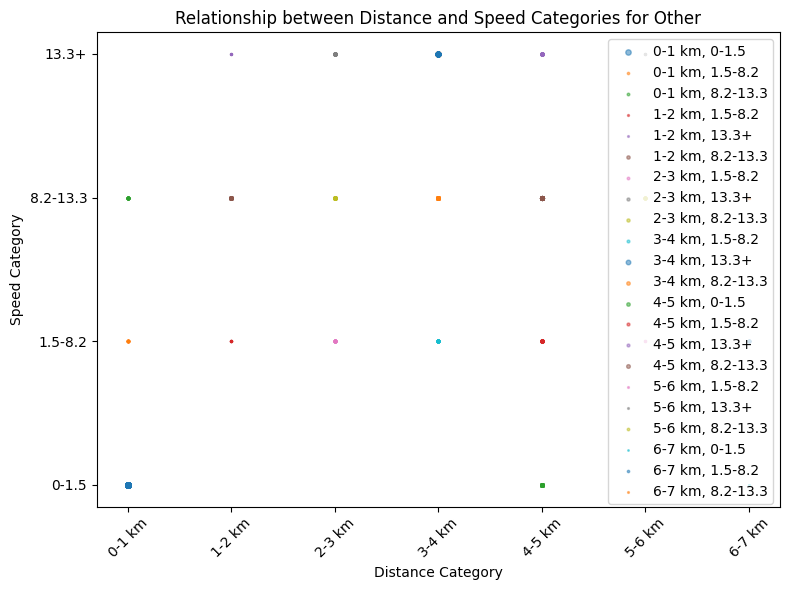

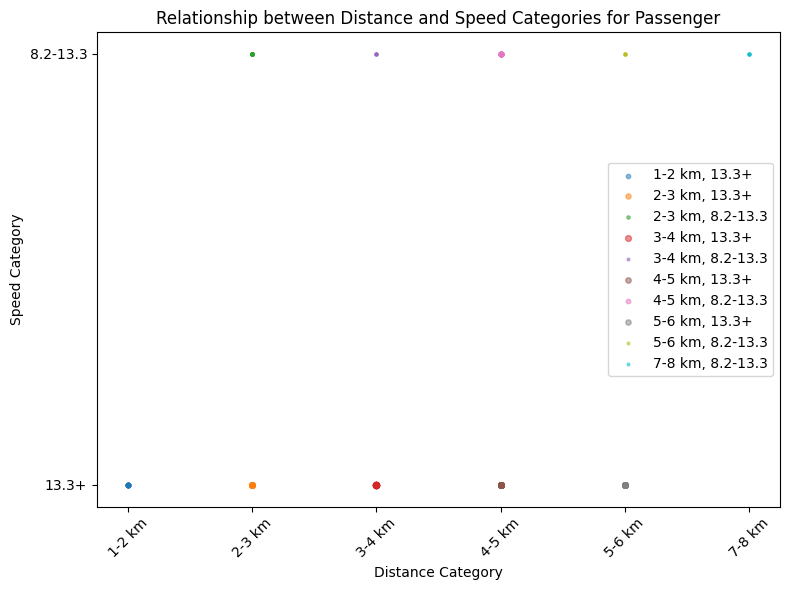

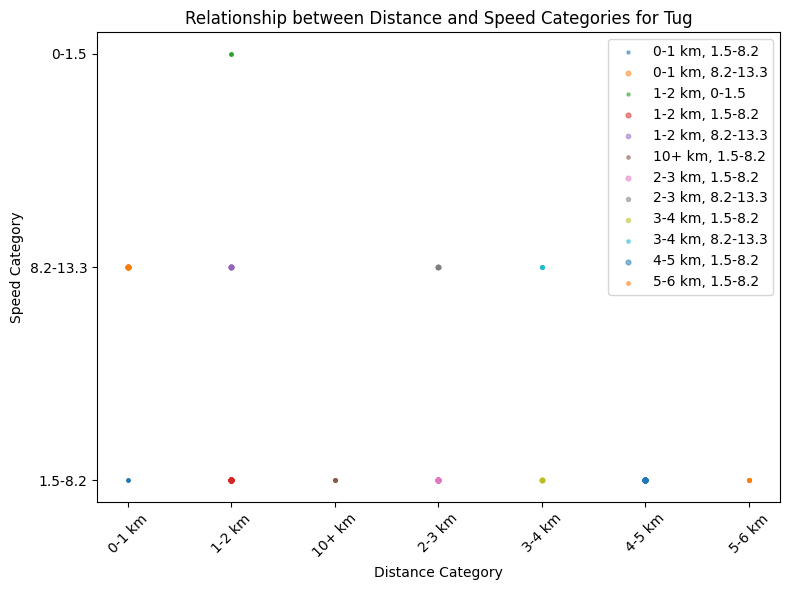

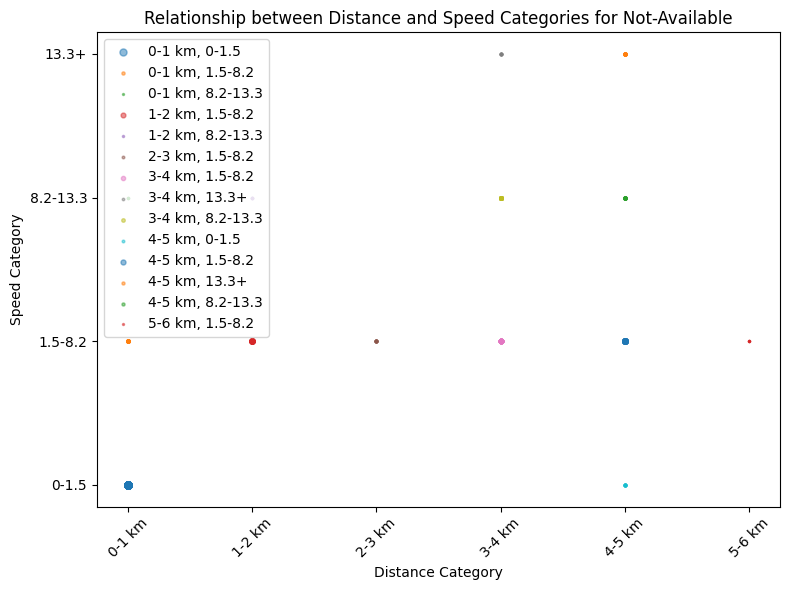

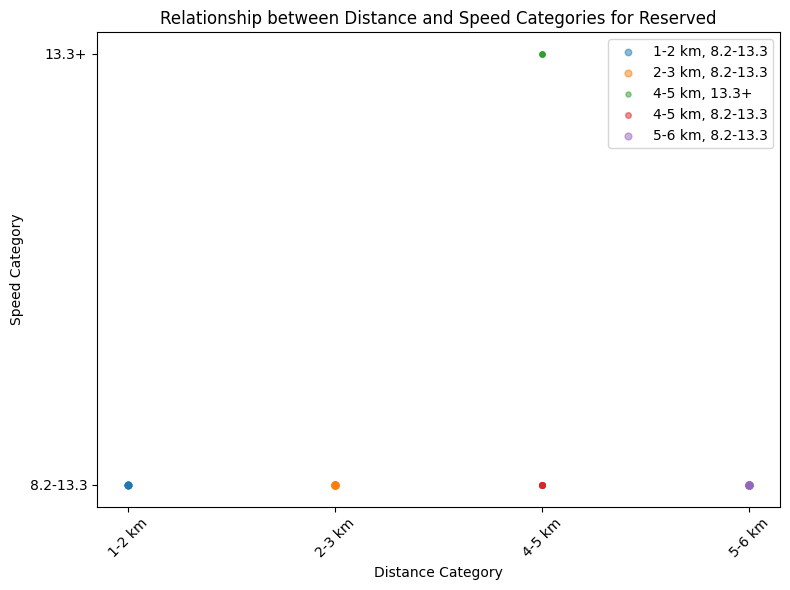

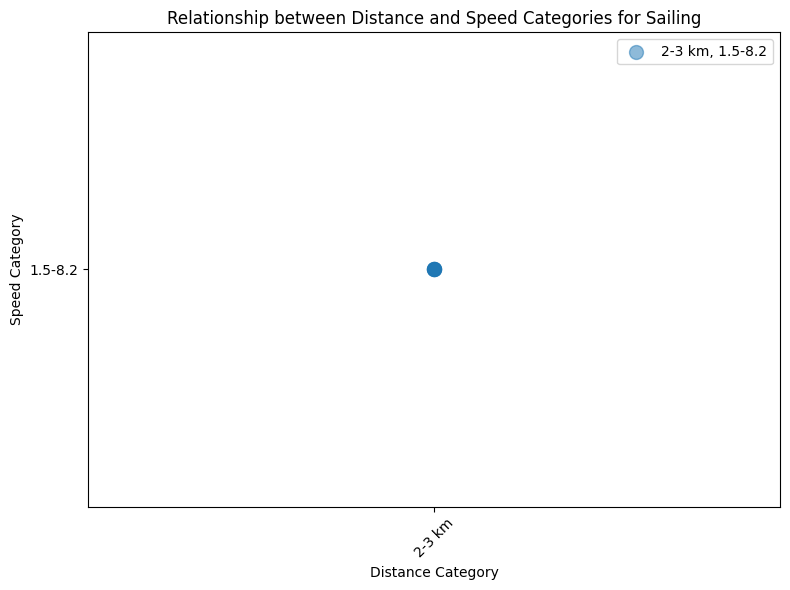

In [20]:
import matplotlib.pyplot as plt

# Count the number of occurrences of each combination of labels for each ship type
ship_type_combinations_counts = filtered_d_train.groupby(['ship_type', 'distance_category', 'speed_category']).size()

# Plotting
for ship_type in filtered_d_train['ship_type'].unique():
    plt.figure(figsize=(8, 6))  # New figure for each ship type
    ship_data = filtered_d_train[filtered_d_train['ship_type'] == ship_type]
    
    # Count the number of occurrences of each combination of labels for this ship type
    label_combinations_counts = ship_type_combinations_counts[ship_type]
    
    # Plot each combination of labels
    for label_combination, count in label_combinations_counts.items():
        distance_category, speed_category = label_combination
        
        ship_data_subset = ship_data[(ship_data['distance_category'] == distance_category) & (ship_data['speed_category'] == speed_category)]
        
        # Calculate size based on occurrence of combination
        size = 100 * (count / label_combinations_counts.sum())
        
        # Plot points with size based on occurrence
        plt.scatter(ship_data_subset['distance_category'], ship_data_subset['speed_category'], s=size, alpha=0.5, label=f'{distance_category}, {speed_category}')

    plt.xlabel('Distance Category')
    plt.ylabel('Speed Category')
    plt.title(f'Relationship between Distance and Speed Categories for {ship_type}')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_9598/4002532474.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_d_train['ship_type_category'] = filtered_d_train['ship_type'].apply(lambda x: ship_type_categories.get(x, 'Other'))


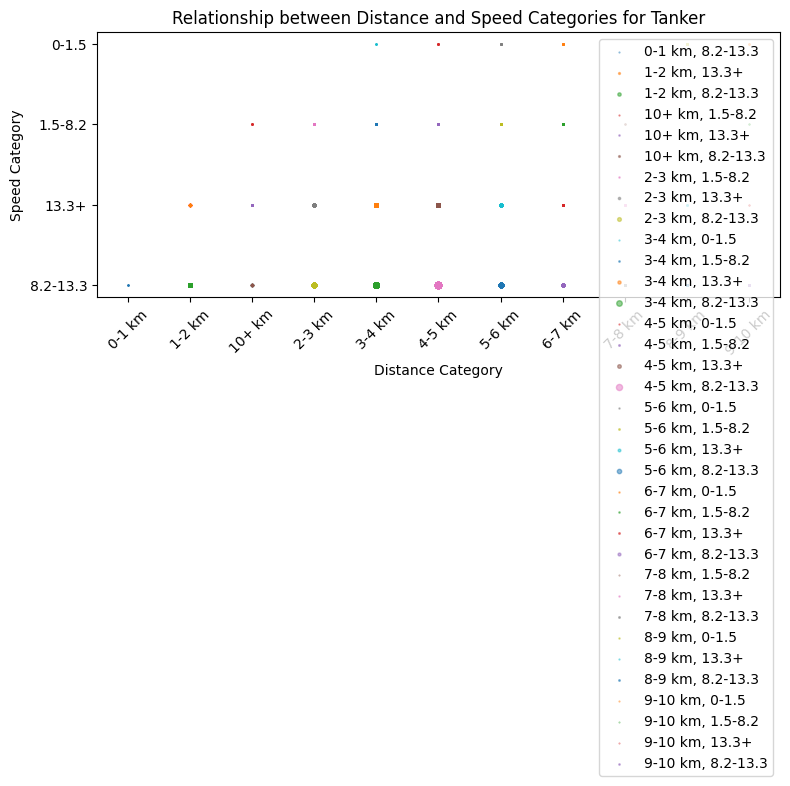

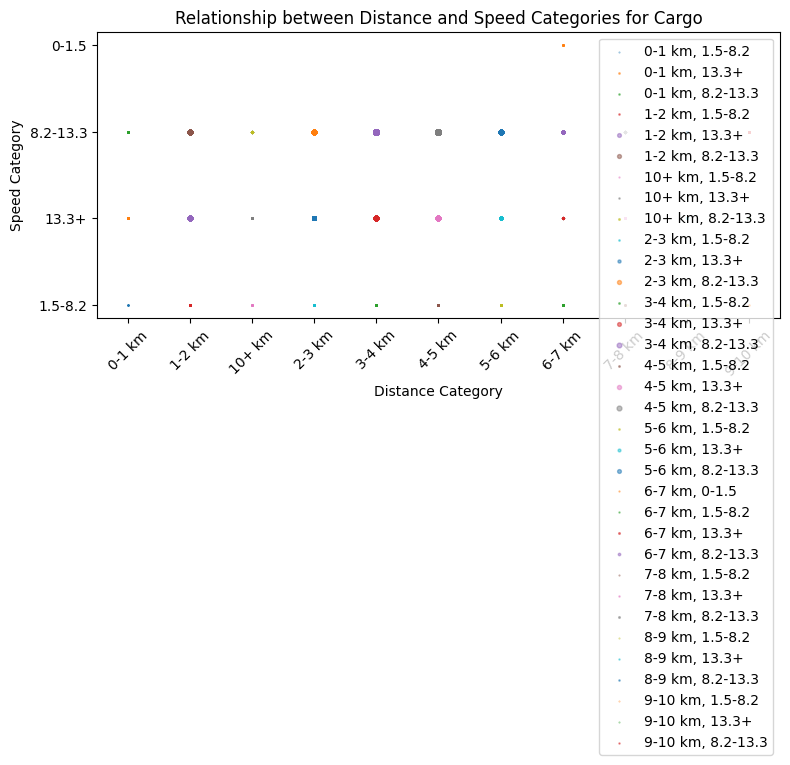

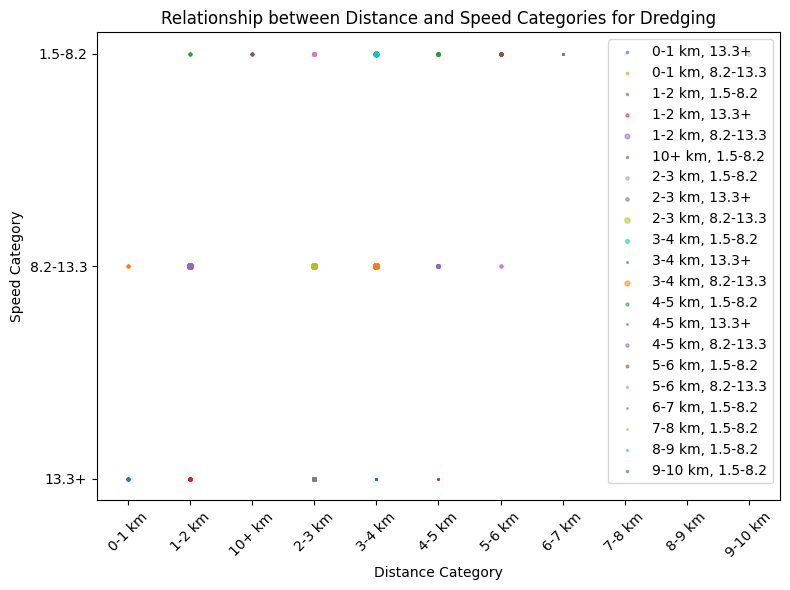

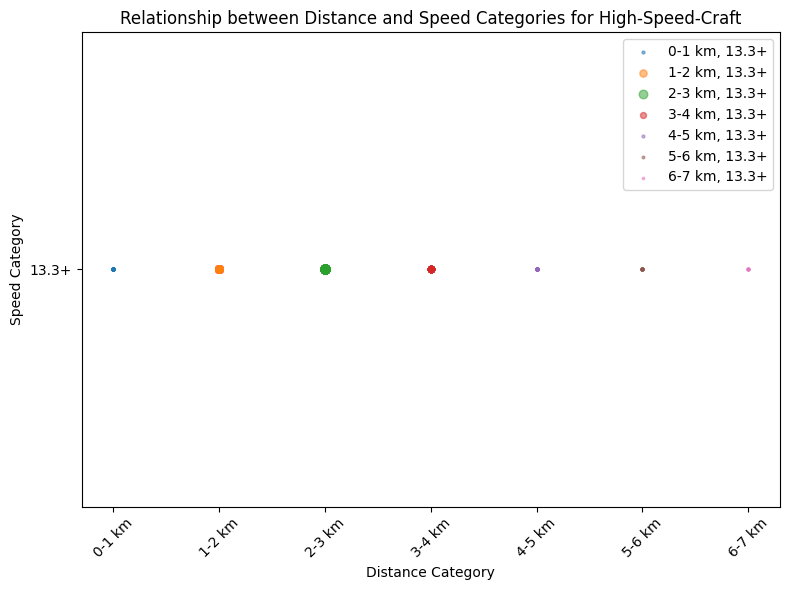

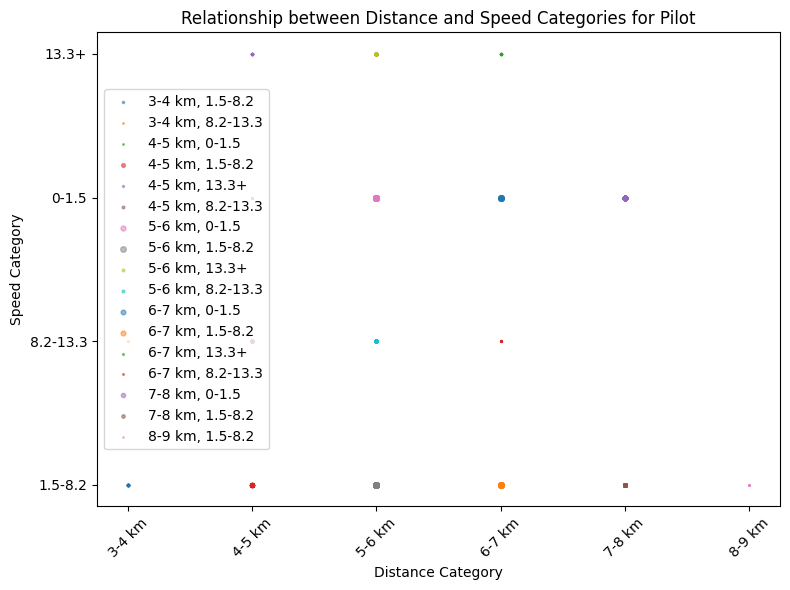

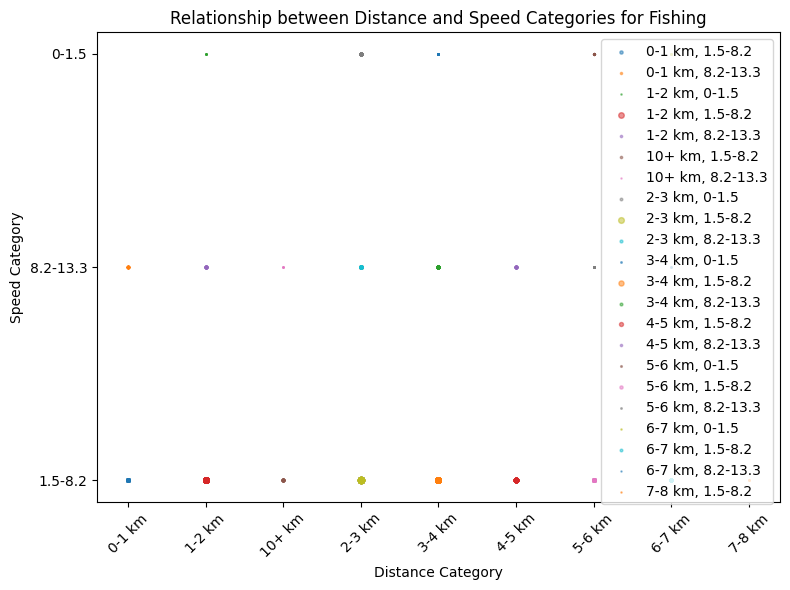

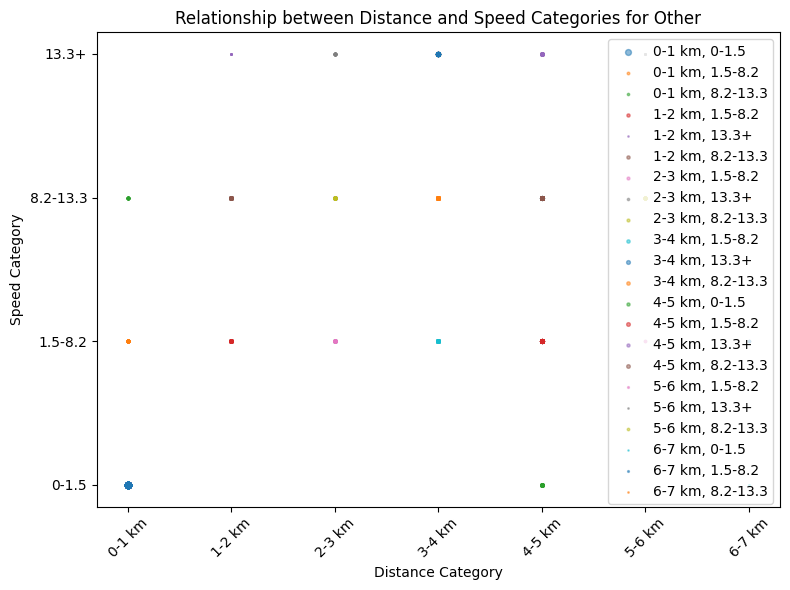

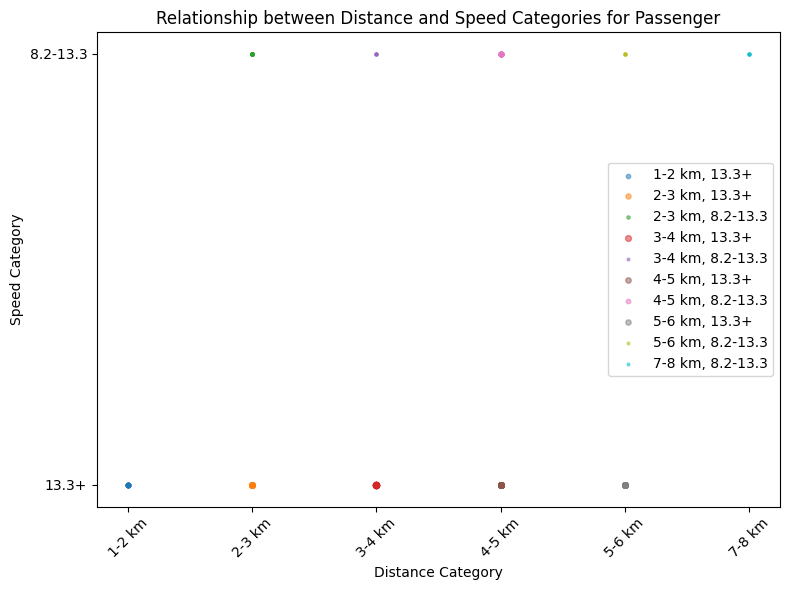

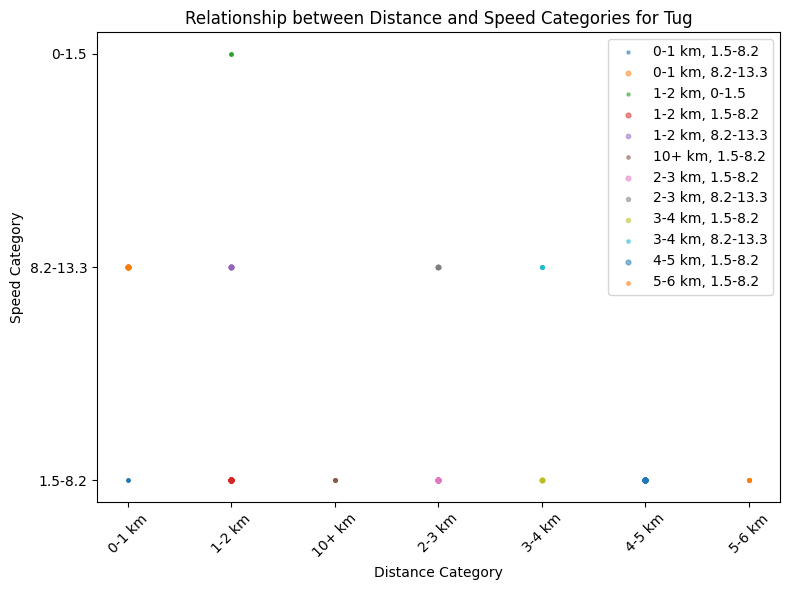

In [21]:
import matplotlib.pyplot as plt

# Define ship type categories
ship_type_categories = {
    'Tanker': 'Tanker',
    'Cargo': 'Cargo',
    'Dredging': 'Dredging',
    'High-Speed-Craft': 'High-Speed-Craft',
    'Fishing': 'Fishing',
    'Passenger': 'Passenger',
    'Tug': 'Tug',
    'Pilot': 'Pilot'
}

# Group ship types into specified categories, labeling others as 'Other'
filtered_d_train['ship_type_category'] = filtered_d_train['ship_type'].apply(lambda x: ship_type_categories.get(x, 'Other'))

# Count the number of occurrences of each combination of labels for each ship type category
ship_type_combinations_counts = filtered_d_train.groupby(['ship_type_category', 'distance_category', 'speed_category']).size()

# Plotting
for ship_type_category in filtered_d_train['ship_type_category'].unique():
    plt.figure(figsize=(8, 6))  # New figure for each ship type category
    ship_data = filtered_d_train[filtered_d_train['ship_type_category'] == ship_type_category]
    
    # Count the number of occurrences of each combination of labels for this ship type category
    label_combinations_counts = ship_type_combinations_counts[ship_type_category]
    
    # Plot each combination of labels
    for label_combination, count in label_combinations_counts.items():
        distance_category, speed_category = label_combination
        
        ship_data_subset = ship_data[(ship_data['distance_category'] == distance_category) & (ship_data['speed_category'] == speed_category)]
        
        # Calculate size based on occurrence of combination
        size = 100 * (count / label_combinations_counts.sum())
        
        # Plot points with size based on occurrence
        plt.scatter(ship_data_subset['distance_category'], ship_data_subset['speed_category'], s=size, alpha=0.5, label=f'{distance_category}, {speed_category}')

    plt.xlabel('Distance Category')
    plt.ylabel('Speed Category')
    plt.title(f'Relationship between Distance and Speed Categories for {ship_type_category}')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()


In [12]:
valid_train_labels

Index(['Cargo at distance 4-5 km with speed 8.2-13.3 is underway-using-engine',
       'Cargo at distance 3-4 km with speed 8.2-13.3 is underway-using-engine',
       'Tanker at distance 4-5 km with speed 8.2-13.3 is underway-using-engine',
       'Cargo at distance 4-5 km with speed 13.3+ is underway-using-engine',
       'Cargo at distance 2-3 km with speed 8.2-13.3 is underway-using-engine',
       'Tanker at distance 3-4 km with speed 8.2-13.3 is underway-using-engine',
       'Cargo at distance 1-2 km with speed 8.2-13.3 is underway-using-engine',
       'Cargo at distance 5-6 km with speed 8.2-13.3 is underway-using-engine',
       'Cargo at distance 3-4 km with speed 13.3+ is underway-using-engine',
       'Cargo at distance 1-2 km with speed 13.3+ is underway-using-engine',
       ...
       'Dredging at distance 5-6 km with speed 8.2-13.3 is restricted-maneuverability',
       'Fishing at distance 3-4 km with speed 0-1.5 is engaged-in-fishing',
       'Cargo at distance 5-6 km

In [11]:
d_train

,filename,distance,speed,activity,ship_type,distance_category,speed_category,label
0,/storage/Imagine_UC6_new/DATA/data_per_station...,3331.0,9.2,underway-using-engine,Tanker,3-4 km,8.2-13.3,Tanker at distance 3-4 km with speed 8.2-13.3 ...
1,/storage/Imagine_UC6_new/DATA/data_per_station...,7933.0,8.7,underway-using-engine,Cargo,7-8 km,8.2-13.3,Cargo at distance 7-8 km with speed 8.2-13.3 i...
2,/storage/Imagine_UC6_new/DATA/data_per_station...,3768.0,12.7,underway-using-engine,Tanker,3-4 km,8.2-13.3,Tanker at distance 3-4 km with speed 8.2-13.3 ...
3,/storage/Imagine_UC6_new/DATA/data_per_station...,2557.0,2.6,underway-using-engine,Tanker,2-3 km,1.5-8.2,Tanker at distance 2-3 km with speed 1.5-8.2 i...
4,/storage/Imagine_UC6_new/DATA/data_per_station...,4377.0,12.7,underway-using-engine,Cargo,4-5 km,8.2-13.3,Cargo at distance 4-5 km with speed 8.2-13.3 i...
...,...,...,...,...,...,...,...,...
13150,/storage/Imagine_UC6_new/DATA/data_per_station...,6612.0,5.8,engaged-in-fishing,Fishing,6-7 km,1.5-8.2,Fishing at distance 6-7 km with speed 1.5-8.2 ...
13151,/storage/Imagine_UC6_new/DATA/data_per_station...,550.0,0.4,restricted-maneuverability,Other,0-1 km,0-1.5,Other at distance 0-1 km with speed 0-1.5 is r...
13152,/storage/Imagine_UC6_new/DATA/data_per_station...,3080.0,25.1,underway-using-engine,High-Speed-Craft,3-4 km,13.3+,High-Speed-Craft at distance 3-4 km with speed...
13153,/storage/Imagine_UC6_new/DATA/data_per_station...,5679.0,11.9,underway-using-engine,Pilot,5-6 km,8.2-13.3,Pilot at distance 5-6 km with speed 8.2-13.3 i...


In [10]:
label_counts =d_train["label"].value_counts()
output_file_path = "/srv/file.txt"

# Open the file in write mode and write the value counts to it
with open(output_file_path, "w") as file:
    file.write(label_counts.to_string())

# Print confirmation
print(f"Value counts saved to: {output_file_path}")

Value counts saved to: /srv/file.txt


In [7]:
valid_train_labels

Index(['Cargo at distance 4-5 km with speed 8.2-13.3 is underway-using-engine',
       'Cargo at distance 3-4 km with speed 8.2-13.3 is underway-using-engine',
       'Tanker at distance 4-5 km with speed 8.2-13.3 is underway-using-engine',
       'Cargo at distance 4-5 km with speed 13.3+ is underway-using-engine',
       'Cargo at distance 2-3 km with speed 8.2-13.3 is underway-using-engine',
       'Tanker at distance 3-4 km with speed 8.2-13.3 is underway-using-engine',
       'Cargo at distance 1-2 km with speed 8.2-13.3 is underway-using-engine',
       'Cargo at distance 5-6 km with speed 8.2-13.3 is underway-using-engine',
       'Cargo at distance 3-4 km with speed 13.3+ is underway-using-engine',
       'Cargo at distance 1-2 km with speed 13.3+ is underway-using-engine',
       ...
       'Dredging at distance 5-6 km with speed 8.2-13.3 is restricted-maneuverability',
       'Fishing at distance 3-4 km with speed 0-1.5 is engaged-in-fishing',
       'Cargo at distance 5-6 km

In [11]:
best_model.clap.save_pretrained('roi/BioLingual/test_model')
best_model.processor.save_pretrained('roi/BioLingual/test_model')

In [5]:
model_path="/srv/CLAP/roi/BioLingual/model"
model = models.CLAPClassifier(model_path, num_classes, sr=self.desired_fs, device=device, similarity_matrix=similarity_matrix, multi_label=False)
clap = ClapAudioModelWithProjection.from_pretrained(model_path)
print("fixed clap.")

linear = nn.Linear(in_features=512, out_features=5)
model_path='davidrrobinson/BioLingual'
processor = AutoProcessor.from_pretrained(model_path)

NameError: name 'num_classes' is not defined

In [12]:
batch_size=8
stop_shuffle=False
sample_dur=10
desired_fs = 48000
wavs_folder= '/storage/UC6_new_data/data/'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Selected CUDA device:", torch.cuda.get_device_name(device))
else:
    print("CUDA is not available. Using CPU.")
# device =torch.device('cuda:0')
log_path = 'roi/BioLingual/logs_test.log'
log_file = open(log_path, mode='w')

# detections = convert_raven_to_ae_format(labels_to_exclude=None)
# detections = detections.loc[~detections.label.isna()]

d_train_path= "ds_split-CLAP/train.txt"
d_test_path= "ds_split-CLAP/test.txt"
# print("path ", d_train_path)
split = np.genfromtxt(d_train_path, dtype='str', delimiter=' ')
d_train_loc = np.array([os.path.join(wavs_folder, i) for i in split[:, 0]])

split = np.genfromtxt(d_test_path, dtype='str', delimiter=' ')
d_test_loc = np.array([os.path.join(wavs_folder, i) for i in split[:, 0]])

# split = np.genfromtxt(d_train_path, dtype='str', delimiter=' ')
# d_train_loc = np.array([os.path.join(wavs_folder, i) for i in split[:, 0]])

# split = np.genfromtxt(d_valid_path, dtype='str', delimiter=' ')
# d_valid_loc = np.array([os.path.join(wavs_folder, i) for i in split[:, 0]])
d_train=u.process_filenames(d_train_loc)
d_test=u.process_filenames(d_test_loc)

train_labels = set(d_train["label"])
# Count the occurrences of each label in d_train
label_counts_train = d_train["label"].value_counts()

valid_train_labels = label_counts_train[label_counts_train >= 5].index


# Filter d_train and d_valid based on valid_train_labels
d_train = d_train[d_train["label"].isin(valid_train_labels)]
test_train_labels = label_counts_train[label_counts_train >= 5].index

d_test = d_test[d_test["label"].isin(test_train_labels)]

# Display the number of unique classes
num_classes = len(valid_train_labels)
ids={lbl: i for i, lbl in enumerate(d_train['label'].unique())}

similarity_matrix=u.similarity(ids,device,distance_weight = 0.6, speed_weight = 0.30,activity_weight = 0.10)
similarity_matrix_distance=u.similarity(ids,device,distance_weight = 1)
similarity_matrix_speed=u.similarity(ids,device,speed_weight = 1)
similarity_matrix_activity=u.similarity(ids,device,activity_weight = 1)
model_path="/srv/CLAP/roi/BioLingual/test_model"
model = models.CLAPClassifier(model_path, num_classes, sr=desired_fs, device=device, similarity_matrix=similarity_matrix, multi_label=False)


dataloader_test = torch.utils.data.DataLoader(
    dataset=u.DatasetWaveform(df=d_test, wavs_folder=wavs_folder, desired_fs=desired_fs,
                              max_duration=sample_dur,ids=ids),
    batch_size=batch_size,
    shuffle=not stop_shuffle)



model = model.to(device)


test_loss, test_metric,test_metric_distance,test_metric_speed,test_metric_activity = u.eval_pytorch_model(
model=model,
dataloader=dataloader_test,
metric_factory=u.Accuracy,
device=device,
similarity_matrix=similarity_matrix,
similarity_matrix_distance=similarity_matrix_distance,
similarity_matrix_speed=similarity_matrix_speed,
similarity_matrix_activity=similarity_matrix_activity,
desc='test',ids=ids)

log_message = json.dumps({
    'test': {
        'loss': test_loss,
        'metric': test_metric,
        'metric_distance': np.mean(test_metric_distance),
        'metric_speed': np.mean(test_metric_speed),
        'metric_activity': np.mean(test_metric_activity),
    }
})

# Write the JSON string to the log file
log_file.write(log_message + '\n')
log_file.flush()

print(log_message)


Selected CUDA device: Tesla T4
fixed clap.


/srv/CLAP/models.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.loss_func = CustomLossFunction(torch.tensor(similarity_matrix).to(device))
test: 100%|██████████| 150/150 [03:26<00:00,  1.38s/it]

CSV file saved successfully.
Training metrics: 0.5004658630449148| Distance: 0.6517093261831846| Speed: 0.29156223893065997 | Activity: 0.2197159565580618
{"test": {"loss": 145.61843907659605, "metric": 0.5004658630449148, "metric_distance": 0.6517093261831846, "metric_speed": 0.29156223893065997, "metric_activity": 0.2197159565580618}}
